# imports

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
#!rm -r /home/jovyan/.local/share/jupyter/kernels/nilmtk
!mamba install tensorflow-gpu==2.10 -y -q
#!mamba install tensorflow-gpu==2.11.0 -y -q
!pip uninstall -y -q nilmtk nilm_metadata
#!pip install -q pandas networkx tables scikit-learn hmmlearn pyyaml matplotlib==3.1.3 xgboost pyts
# Trick to install NILM regardless of its dependencies
#!pip install --no-cache -U git+https://github.com/nilmtk/nilm_metadata.git
#!pip install --no-cache -U git+https://github.com/nilmtk/nilmtk.git@0.4.3
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilmtk@master
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilm_metadata@master

  Cloning https://github.com/nilmtk/nilmtk (to revision master) to /tmp/pip-req-build-clkaifm6
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilmtk /tmp/pip-req-build-clkaifm6
  Resolved https://github.com/nilmtk/nilmtk to commit b2c514479cef478cab872cb635056da08d5352a1
  Preparing metadata (setup.py) ... done
  Created wheel for nilmtk: filename=nilmtk-0.4.0.dev1+git.b2c5144-py3-none-any.whl size=279177 sha256=29994a99ea18b245d56b08e7857540b4aceb4ca72dd978921f733f1f46269c16
  Stored in directory: /tmp/pip-ephem-wheel-cache-1qc8ji5f/wheels/05/a4/8e/b767c3d1714f61fd30ec991c25780be8cc04c474da8205aeee
Successfully built nilmtk
  Cloning https://github.com/nilmtk/nilm_metadata (to revision master) to /tmp/pip-req-build-b4sfefqd
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilm_metadata /tmp/pip-req-build-b4sfefqd
  Resolved https://github.com/nilmtk/nilm_metadata to commit 7ed4bab9062d04cb35c6b6000b451715dc5ab4af
  Prep

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from nilmtk import DataSet
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from joblib import Memory
import pickle
from pprint import pprint

#from nilmtk import DataSet
import multiprocessing as mp

from typing import Dict

!pip install -q scikit-learn-intelex
#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn import pipeline, metrics, linear_model, model_selection, multioutput, tree, ensemble, neural_network
!pip install xgboost -q
import xgboost as xgb

import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split

import numpy as np
#import graphviz
import keras
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
#from ann_visualizer.visualize import ann_viz
from matplotlib import pyplot as plt 
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
# GPU goes brrrrrrrrrrrrrrrrrrrr
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

!pip3 install tqdm -q
from tqdm import tqdm
import NUK

In [4]:
memory = Memory(location='./cache')

# functions

In [7]:
#@memory.cache
#def load_refit_dataset():
#    try:
#        dataset = DataSet('./refit.hdf5')
#
#        samples = []
#        for building_idx, building in dataset.buildings.items():
#            for meter in building.elec.all_meters():
#
#                data = list(meter.load())
#                assert len(data) == 1
#
#                assert len(meter.appliances) < 2
#
#                # TODO: Poglej s kje jemlje sample Jakob.
#                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())
#
#                samples.append(sample)
#                
#        return samples
#
#    except Exception as e:
#        dataset.store.close()
#        raise e
#        
#dataset = load_refit_dataset()

In [5]:
@memory.cache

def load_ukdale_dataset():
    try:
        dataset = DataSet('./ukdale.hdf5')

        samples = []
        for building_idx, building in dataset.buildings.items():
            for meter in building.elec.all_meters():

                data = list(meter.load())
                assert len(data) == 1

                #assert len(meter.appliances) < 2

                # TODO: Poglej s kje jemlje sample Jakob.
                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                samples.append(sample)
                
        return samples

    except Exception as e:
        dataset.store.close()
        raise e
        
dataset = load_ukdale_dataset()

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-2415464166.load_ukdale_dataset...
load_ukdale_dataset()
____________________________________________load_ukdale_dataset - 410.2s, 6.8min


In [9]:
"""
@memory.cache

def load_iawe_dataset():
    try:
        dataset = DataSet('iawe.h5')

        samples = []
        for building_idx, building in dataset.buildings.items():
            for meter in building.elec.all_meters():

                data = list(meter.load())
                assert len(data) == 1

                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                samples.append(sample)
                
        return samples

    except Exception as e:
        dataset.store.close()
        raise e
        
dataset = load_iawe_dataset()

#deletes useless columns from the IAWE dataset
#anze told me that the more for loops you use, the better programmer you are
for i in range(len(dataset)):
    for j in range (len(dataset[i][2])):
        for column in dataset[i][2][j].keys():
            
            if (column[0]=='power' and column[1]=='apparent'): del dataset[i][2][j]['power', 'apparent']
            if (column[0]=='power' and column[1]=='reactive'): del dataset[i][2][j]['power', 'reactive']
            if (column[0]=='current'): del dataset[i][2][j]['current',         '']
            if (column[0]=='frequency'): del dataset[i][2][j]['frequency',       '']
            if (column[0]=='voltage'): del dataset[i][2][j]['voltage',       '']
"""

"\n@memory.cache\n\ndef load_iawe_dataset():\n    try:\n        dataset = DataSet('iawe.h5')\n\n        samples = []\n        for building_idx, building in dataset.buildings.items():\n            for meter in building.elec.all_meters():\n\n                data = list(meter.load())\n                assert len(data) == 1\n\n                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())\n\n                samples.append(sample)\n                \n        return samples\n\n    except Exception as e:\n        dataset.store.close()\n        raise e\n        \ndataset = load_iawe_dataset()\n\n#deletes useless columns from the IAWE dataset\n#anze told me that the more for loops you use, the better programmer you are\nfor i in range(len(dataset)):\n    for j in range (len(dataset[i][2])):\n        for column in dataset[i][2][j].keys():\n            \n            if (column[0]=='power' and column[1]=='apparent'): del dataset[i][2][j]['power

In [10]:
"""
@memory.cache
def load_eco_dataset():
    try:
        dataset = DataSet('eco-Copy1.h5')
        samples = []
        #print(dataset.buildings.items())
        for building_idx, building in dataset.buildings.items():
            print(building_idx, building)
            #if(building_idx!=1): #purely da pridemo do buildinga 2 ki povzroča error hitreje
            for meter in building.elec.all_meters():
                #print(meter)
                #print(meter.instance())
                if(13<=meter.instance()<=14 and building_idx==2):
                    print("Skipped",meter)
                else:
                        if(1<=meter.instance()<=3 and building_idx==4):
                            pass
                        else:
                            print("Works on", meter)
                            data = list(meter.load())
                            assert len(data) == 1
                            sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                            samples.append(sample)
                       
                        #assert len(meter.appliances) < 2

                        # TODO: Poglej s kje jemlje sample Jakob.
                        
        return samples

    except Exception as e:
        dataset.store.close()
        raise e
#universal cleanup of useless data, more clauses should be added if using different datasets        
dataset = load_eco_dataset()
for i in range(len(dataset)):
    for j in range (len(dataset[i][2])):
        for column in dataset[i][2][j].keys():
            if (column[0]=='power' and column[1]=='apparent'): del dataset[i][2][j]['power', 'apparent']
            if (column[0]=='power' and column[1]=='reactive'): del dataset[i][2][j]['power', 'reactive']
            if (column[0]=='current'): del dataset[i][2][j]['current',         '']
            if (column[0]=='frequency'): del dataset[i][2][j]['frequency',       '']
            if (column[0]=='voltage'): del dataset[i][2][j]['voltage',       '']
            if (column[0]=='phase_angle'): del dataset[i][2][j]['phase_angle',       '']
"""

'\n@memory.cache\ndef load_eco_dataset():\n    try:\n        dataset = DataSet(\'eco-Copy1.h5\')\n        samples = []\n        #print(dataset.buildings.items())\n        for building_idx, building in dataset.buildings.items():\n            print(building_idx, building)\n            #if(building_idx!=1): #purely da pridemo do buildinga 2 ki povzroča error hitreje\n            for meter in building.elec.all_meters():\n                #print(meter)\n                #print(meter.instance())\n                if(13<=meter.instance()<=14 and building_idx==2):\n                    print("Skipped",meter)\n                else:\n                        if(1<=meter.instance()<=3 and building_idx==4):\n                            pass\n                        else:\n                            print("Works on", meter)\n                            data = list(meter.load())\n                            assert len(data) == 1\n                            sample = (building_idx, list([a.type[\'type\']

In [11]:
"""
@memory.cache
def load_eco_dataset():
    try:
        dataset = DataSet('eco.h5')
        samples = []
        #print(dataset.buildings.items())
        for building_idx, building in dataset.buildings.items():
            print(building_idx, building)
            #if(building_idx!=1): #purely da pridemo do buildinga 2 ki povzroča error hitreje
            for meter in building.elec.all_meters():
                #print(meter)
                #print(meter.instance())
                if(13<=meter.instance()<=14 and building_idx==2):
                    print("preskocil",meter)
                else:
                        if(1<=meter.instance()<=3 and building_idx==4):
                            pass
                        else:
                            print("dela na", meter)
                            data = list(meter.load())
                            assert len(data) == 1
                            sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())
                            samples.append(sample)
                        #assert len(meter.appliances) < 2
                        # TODO: Poglej s kje jemlje sample Jakob.
        return samples
    except Exception as e:
        dataset.store.close()
        raise e
#for i in range(5):        
#    try: 
dataset = load_eco_dataset()
#    except: 
#        print("haha")
#        continue
for i in range(len(dataset)):
    for j in range (len(dataset[i][2])):
        for stolpec in dataset[i][2][j].keys():
            if (stolpec[0]=='power' and stolpec[1]=='apparent'): del dataset[i][2][j]['power', 'apparent']
            if (stolpec[0]=='power' and stolpec[1]=='reactive'): del dataset[i][2][j]['power', 'reactive']
            if (stolpec[0]=='current'): del dataset[i][2][j]['current',         '']
            if (stolpec[0]=='frequency'): del dataset[i][2][j]['frequency',       '']
            if (stolpec[0]=='voltage'): del dataset[i][2][j]['voltage',       '']
            if (stolpec[0]=='phase_angle'): del dataset[i][2][j]['phase_angle',       '']
#print(dataset[0])
"""

'\n@memory.cache\ndef load_eco_dataset():\n    try:\n        dataset = DataSet(\'eco.h5\')\n        samples = []\n        #print(dataset.buildings.items())\n        for building_idx, building in dataset.buildings.items():\n            print(building_idx, building)\n            #if(building_idx!=1): #purely da pridemo do buildinga 2 ki povzroča error hitreje\n            for meter in building.elec.all_meters():\n                #print(meter)\n                #print(meter.instance())\n                if(13<=meter.instance()<=14 and building_idx==2):\n                    print("preskocil",meter)\n                else:\n                        if(1<=meter.instance()<=3 and building_idx==4):\n                            pass\n                        else:\n                            print("dela na", meter)\n                            data = list(meter.load())\n                            assert len(data) == 1\n                            sample = (building_idx, list([a.type[\'type\'] for 

In [12]:
"""
count = 0
included_device_tab = [3,4,8,10,11,60,64,65,66,67,101,102,105,106,107]
#print("########################")
for i in range(len(included_device_tab)):
    #print("house: ", dataset[included_device_tab[i]][0])
    #print("device: ", dataset[included_device_tab[i]][1])
    if i < 54:
        nm_samples = round(len(dataset[included_device_tab[i]][2][0].values)/5)
        #print("length: ", nm_samples)
        count += nm_samples
    else: 
        nm_samples = round(len(dataset[included_device_tab[i]][2][0].values))
        #print("length: ", nm_samples)
        count += nm_samples
    #print(i)
    #print("########################")
print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("Number of samples: ", count)
print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
"""

'\ncount = 0\nincluded_device_tab = [3,4,8,10,11,60,64,65,66,67,101,102,105,106,107]\n#print("########################")\nfor i in range(len(included_device_tab)):\n    #print("house: ", dataset[included_device_tab[i]][0])\n    #print("device: ", dataset[included_device_tab[i]][1])\n    if i < 54:\n        nm_samples = round(len(dataset[included_device_tab[i]][2][0].values)/5)\n        #print("length: ", nm_samples)\n        count += nm_samples\n    else: \n        nm_samples = round(len(dataset[included_device_tab[i]][2][0].values))\n        #print("length: ", nm_samples)\n        count += nm_samples\n    #print(i)\n    #print("########################")\nprint("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")\nprint("Number of samples: ", count)\nprint("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")\n'

In [6]:
def data_preparation(dataset):
    X = defaultdict(lambda: [])

    for (idx, appliances, data, good_sections) in dataset:
        if not appliances:
            continue
            
        appliance = appliances[0]
        data = data[0]
    
        samples = [data[good.start:good.end] for good in good_sections]
        X[appliance].extend(samples)
        
    for appliance, samples in X.items():
        print(appliance, len(samples))
        
    return X

prepared_data  = data_preparation(dataset)

boiler 1164
solar thermal pumping station 1161
laptop computer 1443
washer dryer 457
dish washer 193
television 635
light 5771
HTPC 120
kettle 3621
toaster 232
fridge freezer 764
microwave 554
computer monitor 1344
audio system 1364
breadmaker 110
audio amplifier 107
broadband router 407
soldering iron 195
ethernet switch 1361
vacuum cleaner 468
tablet computer charger 61
active subwoofer 30
radio 245
wireless phone charger 457
mobile phone charger 121
coffee maker 349
hair dryer 567
hair straighteners 442
clothes iron 79
oven 461
computer 40
baby monitor 59
charger 654
desktop computer 1339
fan 112
printer 1090
immersion heater 1035
active speaker 59
external hard disk 10
rice cooker 86
running machine 83
washing machine 128
fridge 8
games console 9
modem 34
cooker 45
electric space heater 10
projector 9
freezer 6
network attached storage 2
server computer 44
set top box 62
electric oven 6
electric stove 6


In [7]:
processed_data = {}

for appliance, samples in prepared_data.items():
    processed_samples = []
    for sample in samples:
        sample = sample.resample('7s').ffill(limit=1).fillna(0)
        
        # It should contain at least one sample
        if len(sample) < 2:
            continue
        
        # TODO: Filter < 20W (Poglej Blažev članek
        if not np.any(sample.to_numpy() > 20):
            continue
            
        processed_samples.append(sample)
        
    
    processed_data[appliance] = list(processed_samples)
    
    #processed_data[appliance] = list([s.resample('7s').ffill(limit=1).fillna(0) for s in samples])
    
processed_data.pop('unknown', None);

for k, v in processed_data.items():
    print(k, len(v))

boiler 804
solar thermal pumping station 785
laptop computer 1260
washer dryer 167
dish washer 68
television 200
light 861
HTPC 75
kettle 847
toaster 156
fridge freezer 601
microwave 185
computer monitor 1212
audio system 100
breadmaker 33
audio amplifier 64
broadband router 19
soldering iron 8
ethernet switch 105
vacuum cleaner 465
tablet computer charger 28
active subwoofer 22
radio 44
wireless phone charger 42
mobile phone charger 41
coffee maker 94
hair dryer 558
hair straighteners 433
clothes iron 78
oven 116
computer 31
baby monitor 15
charger 92
desktop computer 750
fan 51
printer 363
immersion heater 975
active speaker 16
external hard disk 7
rice cooker 12
running machine 22
washing machine 39
fridge 8
games console 3
modem 13
cooker 11
electric space heater 7
projector 8
freezer 5
network attached storage 2
server computer 19
set top box 19
electric oven 5
electric stove 4


In [5]:
def test_appliance_augmentator(augmentator, *args, **kwargs):
    X, y, labels = next(augmentator(processed_data, *args, **kwargs))

    f, ax = plt.subplots()
    ax.set_title('Augmented time-series')
    ax.plot(X)
    f.show()
    
    
    
    n_appliances = kwargs.get('n_appliances_per_sample', None)
    f, ax = plt.subplots()

    
    print('Number of positive datapoints per appliance')
    for mask, label in zip(y, labels):
        if np.sum(mask) == 0:
            continue
        
        print(f'{label}:\t {np.sum(mask)}')
        

        tmp = X.copy()
        tmp[~mask] = 0
        ax.plot(tmp, linestyle=None, marker='.', label=label, alpha=0.5)
        #ax.plot(np.ma.masked_where(mask, np.full_like(X, idx)), marker='.', label=label)
    

    f.legend(title='markers based on mask')
    f.show()
    
from typing import Iterator, List, Tuple

def appliance_augmentator(dataset:Dict[str,list], sample_length:int, n_appliances_per_sample:int, random_state:int=None) -> Iterator[Tuple[np.ndarray, np.ndarray, List[str]]]:
    
    # Initialize seeded random number generator
    rng = np.random.default_rng(seed=random_state)
    
    # How many appliances are mixed together
    N = n_appliances_per_sample
    
    # Sample length / Window size
    L = sample_length
    
    # Noise floor
    NOISE_FLOOR = 20.0
    
    # Get all available appliances
    appliance_names = tuple(dataset.keys())
    
    # How many appliances are there?
    n_appliances = len(appliance_names)
    print("Number of appliances: ", n_appliances)
    # Start endless generator of samples
    while True:
        # pre-allocate array for time series
        series = np.zeros(L, dtype=np.float64)
        
        # pre-allocate boolean array for masks
        labels = np.zeros((n_appliances, L), dtype=bool)
        
        # Select N random appliances (no replace, because same appliance should not appear twice in the same sample)
        # TODO: Relax this limitation in the future, for cases where multiple of same appliances are in the same household
        for appliance_idx in rng.choice(n_appliances, size=N, replace=False):
            appliance_name = appliance_names[appliance_idx]

            # Pick random sample of a selected appliance
            n_available_samples = len(dataset[appliance_name])
            sample_idx = rng.choice(n_available_samples)
            
            # retrieve sample as NumPy array with appropriate dimensions
            sample_series = dataset[appliance_name][sample_idx].iloc[:].to_numpy().squeeze(axis=-1)
            
            # If sample is too short (shorter than L), give padding on both sides.
            if len(sample_series) <= L:
                padding = L // 2
                sample_series = np.pad(sample_series, (padding, padding), mode='constant', constant_values=0)
            
            
            # The total length of sample time-series
            sample_len = len(sample_series)
            
            # Sanity check(s)
            assert sample_len >= L, f'Sample length should be equal or larger than L: {sample_len} >= {L}'
            
            sample_offset = rng.choice(sample_len - L)
            
            sample = sample_series[sample_offset:sample_offset+L]
            
            # TODO: Currently, we ignore device in idle state (x =< NOISE_FLOOR)
            mask = sample > NOISE_FLOOR  # find samples that are above noise floor
            
            series[:] += sample
            labels[appliance_idx, :] |= mask  # logical ORing the mask
            
        # Add random (constant) offset
        #series += rng.random() * (NOISE_FLOOR)
            
        # There has to be two samples present. Even though we combined two subsets, one or both could be empty.
        # Workaround until area of interest is implemented.
        if not (np.sum([(np.any(label) > 0) for label in labels]) == N):
            continue
            
        yield series, labels, appliance_names
        
        
        
import multiprocessing as mp



def process(random_state):
    # Initialize internal seeded random number generator
    rng = np.random.default_rng(seed=random_state)
    
    # Try to generate valid sample
    #while True:
    # pre-allocate array for time series
    series = np.zeros(L, dtype=np.float64)

    # pre-allocate boolean array for masks
    labels = np.zeros((n_appliances, L), dtype=bool)

    # Select N random appliances (no replace, because same appliance should not appear twice in the same sample)
    # TODO: Relax this limitation in the future, for cases where multiple of same appliances are in the same household
    # h
    for appliance_idx in rng.choice(n_appliances, size=N, replace=False):
        appliance_name = appliance_names[appliance_idx]

        # Pick random sample of a selected appliance
        n_available_samples = len(dataset[appliance_name])
        sample_idx = rng.choice(n_available_samples)

        # retrieve sample as NumPy array with appropriate dimensions
        sample_series = dataset[appliance_name][sample_idx].iloc[:].to_numpy().squeeze(axis=-1)

        # If sample is too short (shorter than L), give padding on both sides.
        if len(sample_series) <= L:
            padding = L // 2
            sample_series = np.pad(sample_series, (padding, padding), mode='constant', constant_values=0)


        # The total length of sample time-series
        sample_len = len(sample_series)

        # Sanity check(s)
        assert sample_len >= L, f'Sample length should be equal or larger than L: {sample_len} >= {L}'

        while True:
            sample_offset = rng.choice(sample_len - L)
            sample = sample_series[sample_offset:sample_offset+L]
            
            # TODO: Currently, we ignore device in idle state (x =< NOISE_FLOOR)
            mask = sample > NOISE_FLOOR  # find samples that are above noise floor
            
            if np.any(mask):
                break



        series[:] += sample
        labels[appliance_idx, :] |= mask  # logical ORing the mask

    # Add random (constant) offset
    #series += rng.random() * (NOISE_FLOOR)

    # There has to be two samples present. Even though we combined two subsets, one or both could be empty.
    # Workaround until area of interest is implemented.
    #if (np.sum([(np.any(label) > 0) for label in labels]) == N):
    #    break

    return series, labels, appliance_names
            


def parallel_appliance_augmentator(_dataset:Dict[str,list], sample_length:int, n_appliances_per_sample:int, n_samples:int, random_state:int=None) -> list:
    import sys
    
    global N, L, NOISE_FLOOR, appliance_names, n_appliances, dataset
    
    dataset = _dataset

    # How many appliances are mixed together
    N = n_appliances_per_sample

    # Sample length / Window size
    L = sample_length

    # Noise floor
    NOISE_FLOOR = 20.0

    # Get all available appliances
    appliance_names = tuple(dataset.keys())

    # How many appliances are there?
    n_appliances = len(appliance_names)
    
    # if random_state is not defined, generate it on the fly
    if random_state == None:
        random_state = np.random.randint(0, sys.maxsize)
    
            
    with mp.Pool() as pool:
        outputs = pool.map(process, np.arange(n_samples) + random_state)
        
    return tuple(outputs)


#samples = parallel_appliance_augmentator(processed_data, sample_length=128, n_appliances_per_sample=14, n_samples=256, random_state=42)

In [15]:
import random
import numpy
import math
from sklearn.model_selection import train_test_split


def DevicesDataXY(number_of_datasets: int, 
                  number_of_devices_in_datasets: int, 
                  number_of_all_devices: int):
    
    # This function uses processed_data and shapes it into two lists 
    # one of them contains data from devices (dataX_Y) and one of them names of devices (devicesX_Y).
    # Lists contain multiple datasets specified with number_of_datasets, all of which have 
    # the same number of devices in them, specified by number_of_devices_in_datasets.
    # We choose devices for datasets randomly, thus we have to specify the number of all devices in the REFIT (22) or UKDALE dataset (54).
    
    # we extract the dictionary processed_data into a list AllTable
    AllTable = [[k,v] for k,v in processed_data.items()]
    
    devicesX_Y = []
    dataX_Y = []
    
    # for loop goes over all datasets
    for i in range(0,number_of_datasets):    
        devicesY = []
        dataY = []
        j = 0
        
        # while loop goes over all devices in datasets
        while j < number_of_devices_in_datasets:
            
            # we get a random number with random library
            random_number = random.randrange(number_of_all_devices)
            
            # we use the random number to get a random device and random data that belongs to it from AllTable
            random_device = AllTable[random_number][0]
            random_data = AllTable[random_number][1]
            
            # we append the device and its data if it doesn't already exist 
            # and thus avoid having the same device more then once in the same dataset
            if random_device not in devicesY:
                devicesY.append(random_device)
                dataY.append(random_data)
                j += 1
        
        devicesX_Y.append(devicesY)
        dataX_Y.append(dataY)
    
    return devicesX_Y, dataX_Y


def DevicesDataHoly5(dataset_name: list):
    
    # This function does the same as DevicesDataXY except it makes only one dataset
    # and the dataset doesn't have randomly selected devices, but it has particular 5 devices:
    # Fridge, Washing Machine, Dish Washer, Microwave, Kettle.
    
    # we extract the dictionary processed_data into a list AllTable
    AllTable=[[k,v] for k,v in processed_data.items()]
    
    devicesX_Y, dataX_Y, devicesY, dataY = [], [], [], []
    
    # the holy 5 devices are in this order in our processed_data from refit
    if dataset_name == "refit": nm_div = [0,3,4,11,12]
    
    # the holy 5 devices are in this order in our processed_data from uk-dale
    elif dataset_name == "uk-dale": nm_div = [42,41,4,11,8]
    
    else: 
        print("Wrong name of the dataset, write either refit or uk-dale") 
    
    # we go over the AllTable and append devices and data for the holy 5 devices
    for i in range(5):
        number = nm_div[i]
        device = AllTable[number][0]
        data = AllTable[number][1]
        devicesY.append(device)
        dataY.append(data)
    
    # we make a useless step because it works better with other functions that way
    devicesX_Y.append(devicesY)
    dataX_Y.append(dataY)
    
    return devicesX_Y, dataX_Y


def ListsToDictlist(devices: list, data: list, number_of_devices: int):
    
    # This function takes lists from DevicesDataXY or DevicesDataHoly5 and
    # turns each of the sublists into a dictionary and then appends those dicitonaries into a list. 
    
    Dictlist=[]
    
    # we make dictionaries out of lists that we input and append them to list of dictionaries (Dictlist)
    for i in range(0,number_of_devices):
        dictionary=dict(zip(devices[i], data[i]))
        Dictlist.append(dictionary)
        
    return Dictlist


def Generate4(Dictlist: list, 
              sample_length: int, 
              n_appliances_per_sample: int, 
              dataset_number: int):
    
    # This function generates x_train, x_test, y_train, y_test, labels datasets 
    # using the appliance_augmentator function and the Dictlist
    
    X, Y, labels = [], [], None
    
    generator = appliance_augmentator(Dictlist[dataset_number], 
                                      sample_length=sample_length, 
                                      n_appliances_per_sample=n_appliances_per_sample, 
                                      random_state=0xDEADBEEF)
    
    for idx, (_x, _y, labels) in zip(range(120_000), generator):
        X.append(_x), Y.append(_y)
        
    X, Y = np.asarray(X), np.asarray(Y)
    y = np.any(Y, axis=-1) > 0
    sample_weight = np.sum(Y, axis=-1) / 128
    
    # split into train test sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # adds the needed dimension
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    
    return x_train, x_test, y_train, y_test, labels


def Generate4Upgraded(Dictlist: list, 
              sample_length: int, 
              n_appliances_per_sample: int, 
              dataset_number: int,
              number_of_generated_samples: int
                     ):
    
    # This function does the same as Generate4 except here we can specify the number of all generated samples. 
    
    X, Y, labels = [], [], None
    
    generator = parallel_appliance_augmentator(Dictlist[dataset_number], 
                                      sample_length=sample_length, 
                                      n_appliances_per_sample=n_appliances_per_sample,
                                      n_samples=number_of_generated_samples,
                                      random_state=0xDEADBEEF)
    
    for idx, (_x, _y, labels) in zip(range(number_of_generated_samples), generator):
        X.append(_x), Y.append(_y)
        
    X, Y = np.asarray(X), np.asarray(Y)
    y = np.any(Y, axis=-1) > 0
    sample_weight = np.sum(Y, axis=-1) / 128
    
    # split into train test sets
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # add the needed dimension
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    
    return x_train, x_test, y_train, y_test, labels


def GenerateRandom4(Dictlist: list, 
              sample_length: int,  
              dataset_number: int,
              table_of_options: list,
              number_of_generated_samples: int
              ):
    # This function generates x_train, x_test, y_train, y_test, labels; datasets. 
    # Datasets consist of equal parts of options from table of options.
    # EX: If you have table_of_options = [1,2,3,4] the dataset will be 1/4 data with 1 active device, 1/4 data with 2 active devices, ...
    # Dataset is mixed so that samples are randomly dispersed throughout the dataset
    
    # First we calculate the number of samples that needs to be generated for each of the datasets that will be mixed into one
    number_of_generated_samples = number_of_generated_samples / len(table_of_options)
    number_of_generated_samples = int(number_of_generated_samples)
    
    # we introduce np.arrays in appropriate shape by making them as the first dataset with table_of_options[0] active devices
    x_tr, x_te, y_tr, y_te, labels = Generate4Upgraded(Dictlist,
                                                        sample_length,
                                                        table_of_options[0],
                                                        dataset_number,
                                                        number_of_generated_samples)
    
    # we rename them for later use if len(table_of_options) > 1
    x_train = x_tr
    x_test = x_te
    y_train = y_tr
    y_test = y_te
    
    # loading bar
    #print("|>_____|")
    print("1 AD")
    
    # we make the rest of the datasets and append them to the first one
    for i in range(1,len(table_of_options)):
        n_appliances_per_sample = table_of_options[i]
        x_tr, x_te, y_tr, y_te, lab = Generate4Upgraded(Dictlist,
                                                        sample_length,
                                                        n_appliances_per_sample,
                                                        dataset_number,
                                                        number_of_generated_samples)
        x_train = numpy.append(x_train, x_tr, axis=0)
        x_test = numpy.append(x_test, x_te, axis=0)
        y_train = numpy.append(y_train, y_tr, axis=0)
        y_test = numpy.append(y_test, y_te, axis=0)
        print(f"{i+1} AD")
        
    # we print out the final shapes before returning new datasets
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
        
    # loading bar
    print("|->____|")
    
    # Now that we have a dataset that consists of len(table_of_options) datasets with different numbers of active devices,
    # we just have to make the final dataset that will be made of exactly the same samples but in a random order.
    
    # To do so first introduce new tables  
    tm_train, tm_test = [], []
    
    # We adjust the number_of_generated_samples back to its original value
    number_of_generated_samples = int(number_of_generated_samples*len(table_of_options))
    #print("number_of_generated_samples: ", number_of_generated_samples)
    
    # we fill tables with integers in order 1,2,3,4,5,6...
    
    #for m in range(1,int(number_of_generated_samples*0.8)):
    #print("range(1,",int(math.floor((number_of_generated_samples*0.8)/len(table_of_options))*len(table_of_options)-1),")")
    for m in range(1,int(math.floor((number_of_generated_samples*0.8)/len(table_of_options))*len(table_of_options)-1)):
        tm_train.append(m)
    
    #for n in range(1,int(number_of_generated_samples*0.2)):
    #print("range(1,",int(math.floor((number_of_generated_samples*0.2)/len(table_of_options))*len(table_of_options)-1),")")
    for n in range(1,int(math.floor((number_of_generated_samples*0.2)/len(table_of_options))*len(table_of_options)-1)):
        tm_test.append(n)
    
    # we shuffle the order of those integers so that it is random
    random.shuffle(tm_train)
    random.shuffle(tm_test)
    
    # loading bar
    print("|-->___|")
    
    # we introduce np.arrays in an appropriate shape by assigning the first sample of the final datasets to be the first samples of the first datasest
    x_train_random = np.expand_dims(x_train[0], axis=0)
    x_test_random = np.expand_dims(x_test[0], axis=0)
    y_train_random = np.expand_dims(y_train[0], axis=0)
    y_test_random = np.expand_dims(y_test[0], axis=0)
    
    # loading bar
    print("|--->__|")
    
    # we append to the arrays by using random order of tm_train
    # to make x and y array in the same random order (because we move the same random row in x and y train dataset)
    
     
    # we also split x : y = 80 : 20
    #for g in range(0,int(number_of_generated_samples*0.8-1)):
    #print("range(0,",int(number_of_generated_samples*0.8-1),")")
    #print("range(0,",int(math.floor((number_of_generated_samples*0.8)/len(table_of_options))*len(table_of_options)-3),")")
    for g in range(0,int(math.floor((number_of_generated_samples*0.8)/len(table_of_options))*len(table_of_options)-3)):
        
        # we add the needed dimension ex: (256, 1) -> (1, 256, 1)
        x_applicable = np.expand_dims(x_train[tm_train[g]], axis=0)
        y_applicable = np.expand_dims(y_train[tm_train[g]], axis=0)
        
        # we append the applicable lists to the dataset
        x_train_random = numpy.append(x_train_random, x_applicable, axis=0)
        y_train_random = numpy.append(y_train_random, y_applicable, axis=0)
        
        # we print out a message for every 10k appended to preserve your sanity
        if g % 10_000 == 0: print("k*10k: ", g)
        
        if g > 95980: print("g je ", g)
    # loading bar
    print("|---->_|")    
    
    # we append to the arrays by using random order of tm_test
    # to make the array in the same random order    
    #for h in range(0,int(number_of_generated_samples*0.2-1)): 
    #print("range(0,",int(math.floor((number_of_generated_samples*0.2)/len(table_of_options))*len(table_of_options)-3),")")
    for h in range(0,int(math.floor((number_of_generated_samples*0.2)/len(table_of_options))*len(table_of_options)-3)): 
        
        # we add the needed dimension ex: (256, 1) -> (1, 256, 1)
        x_app = np.expand_dims(x_test[tm_test[h]],axis=0)
        y_app = np.expand_dims(y_test[tm_test[h]],axis=0)
        
        # we append the applicable lists to the dataset
        x_test_random = numpy.append(x_test_random, x_app, axis=0)
        y_test_random = numpy.append(y_test_random, y_app, axis=0)
        
        # we print out a message for every 10k appended to preserve your sanity
        if h%10_000==0: print("k*10k: ", h)
        
    # loading bar
    print("|----->|")    
    
    # we print out the final shapes before returning new datasets
    print(x_train_random.shape, x_test_random.shape, y_train_random.shape, y_test_random.shape)
    
    return x_train_random, x_test_random, y_train_random, y_test_random, labels


def class_weights_tool(y_test):
    
    # This function returns class weights for each device in a prticular dataset in a form of a dicitionary.
    # It does so by simply counting how many times the device is present througout the dataset.
    
    # inspired by ronnie coleman
    light_weight, nums = [], []
    
    # this for loop goes over the collumns of the y_test dataset
    for j in range(0,len(y_test[0])):             
        
        count=0
        
        # gives 0,1,2,3,4,5,6....
        nums.append(j)
        
        # this loop goes over the rows in the y_test dataset
        for i in range(0,len(y_test)):
            
            # we count Trues in the whole column of y_test dataset
            if y_test[i][j] == True: count+=1     
        
        # we append Trues for the column of y_test dataset to the list light_weight
        light_weight.append(count)
        
    # makes the dictionary    
    class_weights_dictionary = dict(zip(nums, light_weight))             
    
    return class_weights_dictionary

# Models

In [9]:
import numpy as np
import warnings
import math

from keras.models import Model
from keras.layers import Flatten, Dense, Input, GRU, BatchNormalization, LSTM, Bidirectional, AveragePooling1D
from keras.layers import Conv1D, Conv1DTranspose, LocallyConnected1D, SeparableConv1D, ConvLSTM1D
from keras.layers import MaxPooling1D, Dropout
from keras.layers import GlobalMaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
#from keras.applications.imagenet_utils import _obtain_input_shape
#from keras.engine.topology import get_source_inputs


#WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
#WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG19_1D(classes,
             window_size,
             gru,
             gru_num,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block4_pool')(x)

    # Block 5
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units
    if gru == True:
        print("GRU enabled")
        x = GRU(gru_num, activation='tanh', recurrent_activation='sigmoid')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg19_1D')
    return model

def VGG11_1D(classes,
             window_size,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = MaxPooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block4_pool')(x)

    # Block 5
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg11_1D')
    return model

def LOL(classes,
             window_size,
             method,
             method_num,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
            
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block4_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units; https://en.wikipedia.org/wiki/Gated_recurrent_unit
    if method == 'gru':
        print("GRU enabled")
        x = GRU(method_num, activation='tanh', recurrent_activation='sigmoid')(x)
        
    # LSTM layer, btw LSTM stands for long short-term memory; https://en.wikipedia.org/wiki/Long_short-term_memory    
    if method == 'lstm':
        print("LSTM enabled")
        x = LSTM(method_num, activation='tanh', recurrent_activation='sigmoid')(x)
    
    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='LOL')
    return model


def LOL2(classes,
             window_size,
             method,
             method_num,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block4_pool')(x)
    
    # Block 5
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv1')(x)
    #x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units; https://en.wikipedia.org/wiki/Gated_recurrent_unit
    if method == 'gru':
        print("GRU enabled")
        x = GRU(method_num, activation='tanh', recurrent_activation='sigmoid')(x)                
        
    if method == 'gru2':
        print("GRU enabled")
        x = GRU(method_num,activation='tanh',recurrent_activation='sigmoid',reset_after=True)(x)        
        
    if method == 'bigru':
        print("Bi-GRU enabled")
        x = Bidirectional(GRU(method_num, activation='tanh', recurrent_activation='sigmoid'))(x)
        
    if method == 'lstm':
        print("LSTM enabled")
        x = LSTM(method_num, activation='tanh', recurrent_activation='sigmoid')(x)
    
    # LSTM layer, btw LSTM stands for long short-term memory; https://en.wikipedia.org/wiki/Long_short-term_memory
    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='LOL2')
    return model


def LOL3(classes,
             window_size,
             method,
             method_num,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block4_pool')(x)
    
    # Block 5
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv1')(x)
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv2')(x)
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv3')(x)
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv4')(x)
    x = AveragePooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units; https://en.wikipedia.org/wiki/Gated_recurrent_unit
    if method == 'gru':
        print("GRU enabled")
        x = GRU(method_num, activation='tanh', recurrent_activation='sigmoid')(x)                
        
    if method == 'gru2':
        print("GRU enabled")
        x = GRU(method_num,activation='tanh',recurrent_activation='sigmoid',reset_after=True)(x)        
        
    if method == 'bigru':
        print("Bi-GRU enabled")
        x = Bidirectional(GRU(method_num, activation='tanh', recurrent_activation='sigmoid'))(x)
        
    if method == 'lstm':
        print("LSTM enabled")
        x = LSTM(method_num, activation='tanh', recurrent_activation='sigmoid')(x)
    
    # LSTM layer, btw LSTM stands for long short-term memory; https://en.wikipedia.org/wiki/Long_short-term_memory
    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='LOL3')
    return model

def TEST(koef, classes,
             window_size,
             method,
             method_num,
             include_top=True,
             input_tensor=None,
              pooling=None):
    k = koef
    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64*k, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64*k, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128*k, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128*k, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256*k, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256*k, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv1D(256*k, (3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv1D(256*k, (3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512*k, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512*k, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv1D(512*k, (3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv1D(512*k, (3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block4_pool')(x)
    
    # Block 5
    x = Conv1DTranspose(512*k, (3), activation='relu', padding='same', name='block5_tran_conv1')(x)
    x = Conv1DTranspose(512*k, (3), activation='relu', padding='same', name='block5_tran_conv2')(x)
    x = Conv1DTranspose(512*k, (3), activation='relu', padding='same', name='block5_tran_conv3')(x)
    x = Conv1DTranspose(512*k, (3), activation='relu', padding='same', name='block5_tran_conv4')(x)
    x = AveragePooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units; https://en.wikipedia.org/wiki/Gated_recurrent_unit
    if method == 'gru':
        print("GRU enabled")
        x = GRU(method_num, activation='tanh', recurrent_activation='sigmoid')(x)                
        
    if method == 'gru2':
        print("GRU enabled")
        x = GRU(method_num,activation='tanh',recurrent_activation='sigmoid',reset_after=True)(x)        
        
    if method == 'bigru':
        print("Bi-GRU enabled")
        x = Bidirectional(GRU(method_num, activation='tanh', recurrent_activation='sigmoid'))(x)
        
    if method == 'lstm':
        print("LSTM enabled")
        x = LSTM(method_num, activation='tanh', recurrent_activation='sigmoid')(x)
    
    # LSTM layer, btw LSTM stands for long short-term memory; https://en.wikipedia.org/wiki/Long_short-term_memory
    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name=f'TEST')
    return model

In [10]:
"""
           TANONI MODEL
"""
from keras.layers import Conv1D, BatchNormalization, Activation, Dropout, Bidirectional, MaxPooling1D, GRU, Dense

def Tanoni():
    model = keras.Sequential([
        
        # Tanoni block 1
        layers.Conv1D(filters=32, kernel_size=(3), padding='same', input_shape=(2550,1)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        # Tanoni block 2
        layers.Conv1D(filters=64, kernel_size=(3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        # Tanoni block 3
        layers.Conv1D(filters=128, kernel_size=(3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        # Tanoni block 4
        layers.Conv1D(filters=256, kernel_size=(3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        # Tanoni block 5
        layers.Conv1D(filters=512, kernel_size=(3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        # BiGRU
        layers.Bidirectional(GRU(64)),
        
        # FCL - Sigmoid
        layers.Dense(5, activation='sigmoid')
        
        #layers.MaxPooling1D(1),
        
        #layers.Activation(activations.sigmoid)
    ])
    return model

# Holy 

## Dataset

In [20]:
"""
                MAKES THE HOLY DATASET
"""
devices, data = DevicesDataHoly5("uk-dale")
dictlist=ListsToDictlist(devices,data,1)
x_train, x_test, y_train, y_test, labels = GenerateRandom4(dictlist, 2550, 0, [1,2,3,4], 120_000)
HolyDataset = [x_train, x_test, y_train, y_test, labels]
pickle.dump(HolyDataset, open('./datasets/rawTS/HolyDatasetDALE.pkl', 'wb'))

Number of appliances:  5
|>_____|
Number of appliances:  5
Number of appliances:  5
Number of appliances:  5
(96000, 2550, 1) (24000, 2550, 1) (96000, 5) (24000, 5)
|->____|
|-->___|
|--->__|
k*10k:  0
k*10k:  10000
k*10k:  20000
k*10k:  30000
k*10k:  40000
k*10k:  50000
k*10k:  60000
k*10k:  70000
k*10k:  80000
k*10k:  90000
g je  95981
g je  95982
g je  95983
g je  95984
g je  95985
g je  95986
g je  95987
g je  95988
g je  95989
g je  95990
g je  95991
g je  95992
g je  95993
g je  95994
g je  95995
g je  95996
|---->_|
k*10k:  0
k*10k:  10000
k*10k:  20000
|----->|
(95998, 2550, 1) (23998, 2550, 1) (95998, 5) (23998, 5)


## Refit

In [12]:
"""
               USES THE HOLY DATASET, OUR
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDataset.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
#model = VGG19_1D(NmDevices, window_size, gru, gru_num)
model = LOL2(NmDevices, window_size, 'gru', 64)
model.build((len(y_train)+len(y_test),window_size,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/LOL2/')
#SaveData = [y_test, x_test, labels]
#pickle.dump(SaveData, open(f'./datasets/rawTS/| iter ({iteration}) [{date}] |/{net_name}_HolyDataset_{epochs}ep_W{window_size}_opt{table_of_options}.pkl', 'wb'))
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

2023-02-15 07:19:51.560341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 07:19:51.893975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38282 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:e1:00.0, compute capability: 8.0


GRU enabled
Model: "LOL2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2550, 1)]         0         
                                                                 
 block1_conv1 (Conv1D)       (None, 2550, 64)          256       
                                                                 
 block1_conv2 (Conv1D)       (None, 2550, 64)          12352     
                                                                 
 block1_pool (AveragePooling  (None, 1275, 64)         0         
 1D)                                                             
                                                                 
 block2_conv1 (Conv1D)       (None, 1275, 128)         24704     
                                                                 
 block2_conv2 (Conv1D)       (None, 1275, 128)         49280     
                                                  

2023-02-15 07:19:58.789392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-02-15 07:19:59.390608: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-15 07:19:59.391424: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-15 07:19:59.391440: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-02-15 07:19:59.392039: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-15 07:19:59.392088: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


750/750 [==============================] - 36s 32ms/step - loss: inf - accuracy: 0.5117
Epoch 2/20
750/750 [==============================] - 24s 32ms/step - loss: inf - accuracy: 0.5134
Epoch 3/20
750/750 [==============================] - 24s 32ms/step - loss: inf - accuracy: 0.5489
Epoch 4/20
750/750 [==============================] - 24s 31ms/step - loss: inf - accuracy: 0.5790
Epoch 5/20
750/750 [==============================] - 24s 31ms/step - loss: inf - accuracy: 0.6027
Epoch 6/20
750/750 [==============================] - 23s 31ms/step - loss: inf - accuracy: 0.6214
Epoch 7/20
750/750 [==============================] - 24s 31ms/step - loss: inf - accuracy: 0.6307
Epoch 8/20
750/750 [==============================] - 23s 31ms/step - loss: inf - accuracy: 0.6413
Epoch 9/20
750/750 [==============================] - 23s 31ms/step - loss: inf - accuracy: 0.6539
Epoch 10/20
750/750 [==============================] - 23s 31ms/step - loss: inf - accuracy: 0.6595
Epoch 11/20
750/750 

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL2/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL2/assets


750/750 [==============================] - 4s 4ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                 precision    recall  f1-score   support

         fridge       0.95      0.92      0.94     14772
washing machine       0.90      0.89      0.89     10509
    dish washer       0.88      0.88      0.88     10465
      microwave       0.91      0.88      0.89     11878
         kettle       0.98      0.93      0.95     12376

      micro avg       0.92      0.90      0.91     60000
      macro avg       0.92      0.90      0.91     60000
   weighted avg       0.92      0.90      0.91     60000
    samples avg       0.94      0.92      0.92     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [13]:
"""
               USES THE HOLY DATASET, TANONI'S
"""

HolyDataset = pickle.load(open('./datasets/rawTS/HolyDataset.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = Tanoni()
model.build((len(y_train)+len(y_test),2550,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=20, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/Tanoni/')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

2023-02-14 07:46:10.904563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 07:46:11.422586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38282 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:e1:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2550, 32)          128       
                                                                 
 batch_normalization (BatchN  (None, 2550, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2550, 32)          0         
                                                                 
 dropout (Dropout)           (None, 2550, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2550, 64)          6208      
                                                                 
 batch_normalization_1 (Batc  (None, 2550, 64)         256       
 hNormalization)                                        

2023-02-14 07:46:17.329817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-02-14 07:46:18.303500: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-14 07:46:18.304302: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-14 07:46:18.304319: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-02-14 07:46:18.304855: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-14 07:46:18.304896: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


750/750 [==============================] - 229s 271ms/step - loss: inf - accuracy: 0.5599
Epoch 2/20
750/750 [==============================] - 204s 272ms/step - loss: inf - accuracy: 0.5847
Epoch 3/20
100/750 [===>..........................] - ETA: 2:57 - loss: inf - accuracy: 0.5768

Exception ignored in: <function UniquePtr.__del__ at 0x7f56915683a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/c_api_util.py", line 70, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [16]:
"""
               USES THE HOLY DATASET, VGG11
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDataset.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
#model = VGG19_1D(NmDevices, window_size, gru, gru_num)
#model = LOL2(NmDevices, window_size, 'gru', 64)
model = VGG11_1D(NmDevices, window_size)
model.build((len(y_train)+len(y_test),window_size,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/VGG11')
#SaveData = [y_test, x_test, labels]
#pickle.dump(SaveData, open(f'./datasets/rawTS/| iter ({iteration}) [{date}] |/{net_name}_HolyDataset_{epochs}ep_W{window_size}_opt{table_of_options}.pkl', 'wb'))
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

Model: "vgg11_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2550, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 2550, 64)          256       
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 1275, 64)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 1275, 128)         24704     
_________________________________________________________________
block2_pool (MaxPooling1D)   (None, 637, 128)          0         
_________________________________________________________________
block3_conv1 (Conv1D)        (None, 637, 256)          98560     
_________________________________________________________________
block3_conv2 (Conv1D)        (None, 637, 256)          196

KeyboardInterrupt: 

In [33]:
"""
               USES THE HOLY DATASET, OUR
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDataset.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
#model = VGG19_1D(NmDevices, window_size, gru, gru_num)
model = LOL3(NmDevices, window_size, 'gru', 64)
model.build((len(y_train)+len(y_test),window_size,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/LOL3')
#SaveData = [y_test, x_test, labels]
#pickle.dump(SaveData, open(f'./datasets/rawTS/| iter ({iteration}) [{date}] |/{net_name}_HolyDataset_{epochs}ep_W{window_size}_opt{table_of_options}.pkl', 'wb'))
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

GRU enabled
Model: "LOL3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2550, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 2550, 64)          256       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 2550, 64)          12352     
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 1275, 64)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 1275, 128)         24704     
_________________________________________________________________
block2_conv2 (Conv1D)        (None, 1275, 128)         49280     
_________________________________________________________________
block2_pool (MaxPooling1D)   (None, 637, 128)     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL3/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL3/assets


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                 precision    recall  f1-score   support

         fridge       0.93      0.92      0.93     14772
washing machine       0.92      0.86      0.89     10509
    dish washer       0.92      0.84      0.88     10465
      microwave       0.91      0.88      0.90     11878
         kettle       0.96      0.94      0.95     12376

      micro avg       0.93      0.89      0.91     60000
      macro avg       0.93      0.89      0.91     60000
   weighted avg       0.93      0.89      0.91     60000
    samples avg       0.94      0.91      0.92     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


## UK-DALE

In [24]:
"""
               USES THE HOLY DATASET, OUR
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
#model = VGG19_1D(NmDevices, window_size, gru, gru_num)
model = LOL2(NmDevices, window_size, 'gru', 64)
model.build((len(y_train)+len(y_test),window_size,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/LOL2_DALE')
#SaveData = [y_test, x_test, labels]
#pickle.dump(SaveData, open(f'./datasets/rawTS/| iter ({iteration}) [{date}] |/{net_name}_HolyDataset_{epochs}ep_W{window_size}_opt{table_of_options}.pkl', 'wb'))
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

GRU enabled
Model: "LOL2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2550, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 2550, 64)          256       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 2550, 64)          12352     
_________________________________________________________________
block1_pool (AveragePooling1 (None, 1275, 64)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 1275, 128)         24704     
_________________________________________________________________
block2_conv2 (Conv1D)        (None, 1275, 128)         49280     
_________________________________________________________________
block2_pool (AveragePooling1 (None, 637, 128)     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL2_DALE/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL2_DALE/assets


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                 precision    recall  f1-score   support

         fridge       1.00      1.00      1.00     15058
washing machine       0.93      0.91      0.92     12498
    dish washer       0.91      0.82      0.87      7843
      microwave       0.98      0.94      0.96     11228
         kettle       0.92      0.95      0.93     13368

      micro avg       0.95      0.93      0.94     59995
      macro avg       0.95      0.92      0.93     59995
   weighted avg       0.95      0.93      0.94     59995
    samples avg       0.96      0.95      0.95     59995

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [25]:
"""
               USES THE HOLY DATASET, TANONI'S
"""

HolyDataset = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = Tanoni()
model.build((len(y_train)+len(y_test),2550,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=20, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/Tanoni_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2550, 32)          128       
_________________________________________________________________
batch_normalization_5 (Batch (None, 2550, 32)          128       
_________________________________________________________________
activation_5 (Activation)    (None, 2550, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2550, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2550, 64)          6208      
_________________________________________________________________
batch_normalization_6 (Batch (None, 2550, 64)          256       
_________________________________________________________________
activation_6 (Activation)    (None, 2550, 64)         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/Tanoni_DALE/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/Tanoni_DALE/assets


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                 precision    recall  f1-score   support

         fridge       1.00      1.00      1.00     15058
washing machine       0.73      0.90      0.81     12498
    dish washer       0.93      0.79      0.86      7843
      microwave       0.69      0.95      0.80     11228
         kettle       0.83      0.90      0.86     13368

      micro avg       0.82      0.92      0.87     59995
      macro avg       0.84      0.91      0.87     59995
   weighted avg       0.84      0.92      0.87     59995
    samples avg       0.81      0.91      0.84     59995

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [17]:
"""
               USES THE HOLY DATASET, VGG11
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
#model = VGG19_1D(NmDevices, window_size, gru, gru_num)
#model = LOL2(NmDevices, window_size, 'gru', 64)
model = VGG11_1D(NmDevices, window_size)
model.build((len(y_train)+len(y_test),window_size,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/VGG11_DALE')
#SaveData = [y_test, x_test, labels]
#pickle.dump(SaveData, open(f'./datasets/rawTS/| iter ({iteration}) [{date}] |/{net_name}_HolyDataset_{epochs}ep_W{window_size}_opt{table_of_options}.pkl', 'wb'))
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

Model: "vgg11_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2550, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 2550, 64)          256       
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 1275, 64)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 1275, 128)         24704     
_________________________________________________________________
block2_pool (MaxPooling1D)   (None, 637, 128)          0         
_________________________________________________________________
block3_conv1 (Conv1D)        (None, 637, 256)          98560     
_________________________________________________________________
block3_conv2 (Conv1D)        (None, 637, 256)          196

2023-01-06 13:10:43.422822: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/VGG11_DALE/assets
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                 precision    recall  f1-score   support

         fridge       0.99      0.99      0.99     15058
washing machine       0.87      0.87      0.87     12498
    dish washer       0.84      0.79      0.81      7843
      microwave       0.91      0.86      0.88     11228
         kettle       0.87      0.91      0.89     13368

      micro avg       0.90      0.90      0.90     59995
      macro avg       0.90      0.88      0.89     59995
   weighted avg       0.90      0.90      0.90     59995
    samples avg       0.92      0.91      0.91     59995

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [30]:
"""
               USES THE HOLY DATASET, OUR
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
#model = VGG19_1D(NmDevices, window_size, gru, gru_num)
#model = LOL2(NmDevices, window_size, 'gru', 64)
model = LOL3(NmDevices, window_size, 'gru', 64)
model.build((len(y_train)+len(y_test),window_size,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/LOL3.1_DALE')
#SaveData = [y_test, x_test, labels]
#pickle.dump(SaveData, open(f'./datasets/rawTS/| iter ({iteration}) [{date}] |/{net_name}_HolyDataset_{epochs}ep_W{window_size}_opt{table_of_options}.pkl', 'wb'))
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

GRU enabled
Model: "LOL3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2550, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 2550, 64)          256       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 2550, 64)          12352     
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 1275, 64)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 1275, 128)         24704     
_________________________________________________________________
block2_conv2 (Conv1D)        (None, 1275, 128)         49280     
_________________________________________________________________
block2_pool (MaxPooling1D)   (None, 637, 128)     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL3.1_DALE/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL3.1_DALE/assets


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                 precision    recall  f1-score   support

         fridge       1.00      1.00      1.00     15058
washing machine       0.94      0.88      0.91     12498
    dish washer       0.95      0.79      0.86      7843
      microwave       0.98      0.93      0.95     11228
         kettle       0.94      0.92      0.93     13368

      micro avg       0.96      0.92      0.94     59995
      macro avg       0.96      0.90      0.93     59995
   weighted avg       0.96      0.92      0.94     59995
    samples avg       0.97      0.93      0.94     59995

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [24]:
"""
               USES THE HOLY DATASET, OUR
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
#model = VGG19_1D(NmDevices, window_size, gru, gru_num)
#model = LOL2(NmDevices, window_size, 'gru', 64)
model = LOL4(NmDevices, window_size, 'gru', 64)
model.build((len(y_train)+len(y_test),window_size,1))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
# |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
model.save(f'./models/rawTS/HolyDataset/LOL4_DALE')
#SaveData = [y_test, x_test, labels]
#pickle.dump(SaveData, open(f'./datasets/rawTS/| iter ({iteration}) [{date}] |/{net_name}_HolyDataset_{epochs}ep_W{window_size}_opt{table_of_options}.pkl', 'wb'))
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

GRU enabled
Model: "LOL4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2550, 1)]         0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 2550, 64)          256       
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 2550, 64)          12352     
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 1275, 64)          0         
_________________________________________________________________
block2_conv1 (Conv1D)        (None, 1275, 128)         24704     
_________________________________________________________________
block2_conv2 (Conv1D)        (None, 1275, 128)         49280     
_________________________________________________________________
block2_pool (MaxPooling1D)   (None, 637, 128)     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL3_DALE/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/LOL3_DALE/assets


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                 precision    recall  f1-score   support

         fridge       1.00      0.99      1.00     15058
washing machine       0.94      0.90      0.92     12498
    dish washer       0.91      0.86      0.89      7843
      microwave       0.99      0.94      0.96     11228
         kettle       0.94      0.92      0.93     13368

      micro avg       0.96      0.93      0.95     59995
      macro avg       0.96      0.92      0.94     59995
   weighted avg       0.96      0.93      0.95     59995
    samples avg       0.97      0.94      0.95     59995

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


# K-Fold experiment

In [53]:
"""
               USES THE HOLY DATASET, OUR, EXPERIMENT WITH KFOLD!!!!!
"""
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import pickle

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Load the datasets
HolyDataset_UKD = pickle.load(open('./datasets/HolyDatasetDALE.pkl', 'rb'))
HolyDataset_REF = pickle.load(open('./datasets/HolyDataset.pkl', 'rb'))

x_UKD, y_UKD, labels_UKD = HolyDataset_UKD[0], HolyDataset_UKD[2], HolyDataset_UKD[4]
class_weights_UKD = class_weights_tool(y_UKD)

x_REF, y_REF, labels_REF = HolyDataset_REF[0], HolyDataset_REF[2], HolyDataset_REF[4]
class_weights_REF = class_weights_tool(y_REF)

# Set the number of folds
n_folds = 5

# Initialize the KFold cross-validator
kf = KFold(n_splits=n_folds, shuffle=True)

# Lists to store the evaluation results for each fold
evaluation_results_UKD_UKD, evaluation_results_UKD_REF, evaluation_results_REF_UKD, evaluation_results_REF_REF = [], [], [], []

# List to store all of the results in tuples
all_results = []

test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]

for i in range(len(test_koef)):
    k = test_koef[i]
    print(f'Using koef {k}')

    # Perform 5-fold cross-validation
    for train_idx, val_idx in kf.split(x_UKD):
        x_train_UKD, x_val_UKD = x_UKD[train_idx], x_UKD[val_idx]
        y_train_UKD, y_val_UKD = y_UKD[train_idx], y_UKD[val_idx]

        model = TEST(k, NmDevices, window_size, 'gru', 128)
        model.build((len(y_train_UKD) + len(y_test_UKD), window_size, 1))
        #model.summary()
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=[NUK.F1Score, NUK.WeightedF1Score(NUK.class_weights_tool(y_test_UKD))])
        lr_scheduler = LearningRateScheduler(scheduler)
        model.fit(x_train_UKD, y_train_UKD, batch_size=batch_size, epochs=epochs, class_weight=class_weights_UKD, callbacks=[lr_scheduler])

        # Evaluate the model on the UKD dataset
        y_pred_UKD = model.predict(x_val_UKD)
        y_pred_tf_UKD = (y_pred_UKD > 0.5)
        report_UKD = metrics.classification_report(y_val_UKD, y_pred_tf_UKD, target_names=labels_UKD, zero_division=0)
        # I prefer to save class. reports in pandas dataframes so i use this function
        report_UKD_DF = NUK.ClassificationReportToDF(report_UKD, labels_UKD)
        report_UKD_DF.rename(columns={report_UKD_DF.columns[0]: "device"}, inplace=True)
        evaluation_results_UKD_UKD.append(report_UKD_DF)

        # Evaluate the model on the REF dataset
        y_pred_REF = model.predict(x_REF)
        y_pred_tf_REF = (y_pred_REF > 0.5)
        report_REF = metrics.classification_report(y_REF, y_pred_tf_REF, target_names=labels_REF, zero_division=0)
        # I prefer to save class. reports in pandas dataframes so i use this function
        report_REF_DF = NUK.ClassificationReportToDF(report_REF, labels_REF)
        report_REF_DF.rename(columns={report_REF_DF.columns[0]: "device"}, inplace = True)
        evaluation_results_UKD_REF.append(report_REF_DF)

    # Print the evaluation results for each fold
    for j, (result_UKD, result_REF) in enumerate(zip(evaluation_results_UKD, evaluation_results_REF)):
        print(f"Fold {j+1} evaluation results for UKD dataset:")
        print(result_UKD_UKD)
        print("-------------------------------------------------")
        print(f"Fold {j+1} evaluation results for REF dataset:")
        print(result_UKD_REF)
        print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
        
    # Perform 5-fold cross-validation
    for train_idx, val_idx in kf.split(x_REF):  # Swap 'x_UKD' with 'x_REF'
        x_train_REF, x_val_REF = x_REF[train_idx], x_REF[val_idx]  # Swap 'x_train_UKD' with 'x_train_REF' and 'x_val_UKD' with 'x_val_REF'
        y_train_REF, y_val_REF = y_REF[train_idx], y_REF[val_idx]  # Swap 'y_train_UKD' with 'y_train_REF' and 'y_val_UKD' with 'y_val_REF'

        model = TEST(k, NmDevices, window_size, 'gru', 128)
        model.build((len(y_train_REF) + len(y_test_REF), window_size, 1))  # Swap 'y_train_UKD' with 'y_train_REF'
        #model.summary()
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=[NUK.F1Score, NUK.WeightedF1Score(NUK.class_weights_tool(y_test_REF))])  # Swap 'y_test_UKD' with 'y_test_REF'
        lr_scheduler = LearningRateScheduler(scheduler)
        model.fit(x_train_REF, y_train_REF, batch_size=batch_size, epochs=epochs, class_weight=class_weights_REF, callbacks=[lr_scheduler])  # Swap 'x_train_UKD' with 'x_train_REF' and 'y_train_UKD' with 'y_train_REF'

        # Evaluate the model on the REF dataset  # Swap 'UKD' with 'REF'
        y_pred_REF = model.predict(x_val_REF)  # Swap 'x_val_UKD' with 'x_val_REF'
        y_pred_tf_REF = (y_pred_REF > 0.5)
        report_REF = metrics.classification_report(y_val_REF, y_pred_tf_REF, target_names=labels_REF, zero_division=0)  # Swap 'y_val_UKD' with 'y_val_REF'
        # I prefer to save class. reports in pandas dataframes so i use this function
        report_REF_DF = NUK.ClassificationReportToDF(report_REF, labels_REF)
        report_REF_DF.rename(columns={report_REF_DF.columns[0]: "device"}, inplace=True)
        evaluation_results_REF_REF.append(report_REF_DF)  # Swap 'evaluation_results_UKD_REF' with 'evaluation_results_REF_REF'

        # Evaluate the model on the UKD dataset  # Swap 'REF' with 'UKD'
        y_pred_UKD = model.predict(x_UKD)  # Swap 'x_REF' with 'x_UKD'
        y_pred_tf_UKD = (y_pred_UKD > 0.5)
        report_UKD = metrics.classification_report(y_UKD, y_pred_tf_UKD, target_names=labels_UKD, zero_division=0)  # Swap 'y_REF' with 'y_UKD'
        # I prefer to save class. reports in pandas dataframes so i use this function
        report_UKD_DF = NUK.ClassificationReportToDF(report_UKD, labels_UKD)
        report_UKD_DF.rename(columns={report_UKD_DF.columns[0]: "device"}, inplace=True)
        evaluation_results_REF_UKD.append(report_UKD_DF)  # Swap 'evaluation_results_UKD_UKD' with 'evaluation_results_REF_UKD'

    # Print the evaluation results for each fold
    for j, (result_REF, result_UKD) in enumerate(zip(evaluation_results_REF_REF, evaluation_results_REF_UKD)):  # Swap 'evaluation_results_UKD_REF' with 'evaluation_results_REF_REF' and 'evaluation_results_REF_UKD' with 'evaluation_results_REF_UKD'
        print(f"Fold {j+1} evaluation results for REF dataset:")  # Swap 'UKD' with 'REF'
        print(result_REF)  # Swap 'result_UKD_REF' with 'result_REF'
        print("-------------------------------------------------")
        print(f"Fold {j+1} evaluation results for UKD dataset:")  # Swap 'REF' with 'UKD'
        print(result_UKD)  # Swap 'result_REF_UKD' with 'result_UKD'
        print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    
    all_results.append((evaluation_results_UKD_UKD,  evaluation_results_UKD_REF, evaluation_results_REF_UKD, evaluation_results_REF_REF))
    
pickle.dump(all_results, open('all_results.pkl', 'wb'))

Using koef 0.1
GRU enabled
Epoch 1/20
600/600 [==============================] - 12s 17ms/step - loss: inf - F1Score: 0.6751 - WeightedF1: 0.7004 - lr: 3.0000e-04
Epoch 2/20
600/600 [==============================] - 10s 17ms/step - loss: inf - F1Score: 0.8090 - WeightedF1: 0.8258 - lr: 3.0000e-04
Epoch 3/20
600/600 [==============================] - 10s 17ms/step - loss: inf - F1Score: 0.8337 - WeightedF1: 0.8498 - lr: 3.0000e-04
Epoch 4/20
600/600 [==============================] - 10s 17ms/step - loss: inf - F1Score: 0.8497 - WeightedF1: 0.8651 - lr: 3.0000e-04
Epoch 5/20
600/600 [==============================] - 10s 17ms/step - loss: inf - F1Score: 0.8584 - WeightedF1: 0.8737 - lr: 3.0000e-04
Epoch 6/20
600/600 [==============================] - 10s 17ms/step - loss: inf - F1Score: 0.8663 - WeightedF1: 0.8815 - lr: 3.0000e-04
Epoch 7/20
600/600 [==============================] - 10s 17ms/step - loss: inf - F1Score: 0.8707 - WeightedF1: 0.8858 - lr: 3.0000e-04
Epoch 8/20
600/600 [=

In [81]:
all_results = pickle.load(open('all_results.pkl', 'rb'))

print('len(all_results) = ', len(all_results))
print('len(all_results[0]) = ', len(all_results[12]))
print('len(all_results[0][0]) = ', len(all_results[12][0]))
print('evaluation_results_UKD_UKD, evaluation_results_UKD_REF, evaluation_results_REF_UKD, evaluation_results_REF_REF')
print(' ')
print(' ')
print(' ')

test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
for i in range(len(test_koef)):
    
    if i not in [2, 3]: continue
    
    print(f'||||||||||||||||||||||||||||{test_koef[i]}|||||||||||||||||||||||||||||')
    for j in range(5):
        print(all_results[0][1][i*5+j])
        print(' ')

        
print(' ')
print(' ')
print(' ')

test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
for i in range(len(test_koef)):
    print(f'||||||||||||||||||||||||||||{test_koef[i]}|||||||||||||||||||||||||||||')
    helper_list = []
    for j in range(5):
        res_df = all_results[0][1][i*5+j]
        helper_list.append(res_df['f1-score'][7])
    print(round(NUK.ListAverage(helper_list)*100, 4))
    print(' ')

        
#for i in range(len(all_results)):
#    print(all_results[i][1][0])
#    print(' ')

len(all_results) =  13
len(all_results[0]) =  4
len(all_results[0][0]) =  65
evaluation_results_UKD_UKD, evaluation_results_UKD_REF, evaluation_results_REF_UKD, evaluation_results_REF_REF
 
 
 
||||||||||||||||||||||||||||0.5|||||||||||||||||||||||||||||
            device  precision  recall  f1-score  support
0           fridge       0.81    0.48      0.60    59042
1  washing machine       0.56    0.90      0.69    42164
2      dish washer       0.52    0.67      0.59    41122
3        microwave       0.70    0.57      0.63    47816
4           kettle       0.64    0.94      0.76    49856
5        micro avg       0.63    0.70      0.66   240000
6        macro avg       0.65    0.71      0.65   240000
7     weighted avg       0.66    0.70      0.65   240000
8      samples avg       0.62    0.68      0.62   240000
 
            device  precision  recall  f1-score  support
0           fridge       0.83    0.34      0.49    59042
1  washing machine       0.55    0.89      0.68    42164
2 

In [48]:
#type(report_REF)
report_REF_DF = NUK.ClassificationReportToDF(report_REF, labels_REF)
report_REF_DF.rename(columns={report_REF_DF.columns[0]: "device"}, inplace = True)
report_REF_DF.columns

Index(['device', 'precision', 'recall', 'f1-score', 'support'], dtype='object')

In [25]:
model = keras.models.load_model('./models/rawTS/HolyDataset/ComplexityAnalysis/PC1*0.7_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred_REF = model.predict(x_test_REF)
y_pred_tf_REF = (y_pred_REF > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test_REF, y_pred_tf_REF, target_names=labels_REF, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

750/750 [==============================] - 4s 5ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                 precision    recall  f1-score   support

         fridge       0.80      0.43      0.56     14772
washing machine       0.54      0.88      0.67     10509
    dish washer       0.55      0.67      0.61     10465
      microwave       0.69      0.53      0.60     11878
         kettle       0.71      0.93      0.80     12376

      micro avg       0.64      0.67      0.66     60000
      macro avg       0.66      0.69      0.65     60000
   weighted avg       0.67      0.67      0.65     60000
    samples avg       0.62      0.64      0.61     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [23]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import pickle

epochs = 20
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Load the datasets
HolyDataset_UKD = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))
HolyDataset_REF = pickle.load(open('./datasets/rawTS/HolyDataset.pkl', 'rb'))

x_UKD, y_UKD, labels_UKD = HolyDataset_UKD[0], HolyDataset_UKD[2], HolyDataset_UKD[4]
class_weights_UKD = class_weights_tool(y_UKD)

x_REF, y_REF, labels_REF = HolyDataset_REF[0], HolyDataset_REF[2], HolyDataset_REF[4]
class_weights_REF = class_weights_tool(y_REF)

# Set the number of folds
n_folds = 20

# Initialize the KFold cross-validator
kf = KFold(n_splits=n_folds, shuffle=True)

random_results = [
    [],
    []
]

# Perform 5-fold cross-validation
for train_idx, val_idx in kf.split(x_UKD):
    x_train_UKD, x_val_UKD = x_UKD[train_idx], x_UKD[val_idx]
    y_train_UKD, y_val_UKD = y_UKD[train_idx], y_UKD[val_idx]

    model = TEST(0.7, NmDevices, window_size, 'gru', 128)
    model.build((len(y_train_UKD) + len(y_val_UKD), window_size, 1))
    #model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=[NUK.F1Score, NUK.WeightedF1Score(NUK.class_weights_tool(y_val_UKD))])
    lr_scheduler = LearningRateScheduler(scheduler)
    model.fit(x_train_UKD, y_train_UKD, batch_size=batch_size, epochs=epochs, class_weight=class_weights_UKD, callbacks=[lr_scheduler])

    # Evaluate the model on the UKD dataset
    y_pred_UKD = model.predict(x_val_UKD)
    y_pred_tf_UKD = (y_pred_UKD > 0.5)
    classification_report = metrics.classification_report(y_val_UKD, y_pred_tf_UKD, target_names=labels_UKD, zero_division=0)
    classification_report_df = NUK.ClassificationReportToDF(classification_report, labels_UKD)
    print(classification_report_df)
    random_results[0].append(classification_report_df)
    

    # Evaluate the model on the REF dataset
    y_pred_REF = model.predict(x_REF)
    y_pred_tf_REF = (y_pred_REF > 0.5)
    classification_report = metrics.classification_report(y_REF, y_pred_tf_REF, target_names=labels_REF, zero_division=0)
    classification_report_df = NUK.ClassificationReportToDF(classification_report, labels_REF)
    print(classification_report_df)
    random_results[1].append(classification_report_df)
    
print(' ')
print(' ')
print(' ')
print('||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')
print(' ')
print(' ')
print(' ')
random_list = [df['f1-score'][7] for df in random_results[1]]
print('Mean = ', NUK.ListAverage(random_list))

GRU enabled
Epoch 1/20
713/713 [==============================] - 38s 49ms/step - loss: inf - F1Score: 0.6735 - WeightedF1: 0.7098 - lr: 3.0000e-04
Epoch 2/20
713/713 [==============================] - 35s 49ms/step - loss: inf - F1Score: 0.8019 - WeightedF1: 0.8200 - lr: 3.0000e-04
Epoch 3/20
713/713 [==============================] - 36s 50ms/step - loss: inf - F1Score: 0.8475 - WeightedF1: 0.8634 - lr: 3.0000e-04
Epoch 4/20
713/713 [==============================] - 36s 50ms/step - loss: inf - F1Score: 0.8718 - WeightedF1: 0.8866 - lr: 3.0000e-04
Epoch 5/20
713/713 [==============================] - 38s 53ms/step - loss: inf - F1Score: 0.8884 - WeightedF1: 0.9007 - lr: 3.0000e-04
Epoch 6/20
713/713 [==============================] - 46s 64ms/step - loss: inf - F1Score: 0.8995 - WeightedF1: 0.9106 - lr: 3.0000e-04
Epoch 7/20
713/713 [==============================] - 42s 59ms/step - loss: inf - F1Score: 0.9053 - WeightedF1: 0.9159 - lr: 3.0000e-04
Epoch 8/20
713/713 [================

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [24]:
random_list = [df['f1-score'][7] for df in random_results[1]]
print('Mean = ', NUK.ListAverage(random_list))

Mean =  0.6295


In [24]:
"""
               USES THE HOLY DATASET, OUR
"""
import NUK
import importlib
importlib.reload(NUK)
import NUK
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold


epochs = 20
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]



# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))

x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
#model = TEST(0.7, NmDevices, window_size, 'gru', 64)
model = NUK.VGG11_1D(NmDevices, window_size)
model.build((len(y_train)+len(y_test),window_size,1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=[NUK.F1Score, NUK.WeightedF1Score(NUK.class_weights_tool(y_test))])
lr_scheduler = LearningRateScheduler(scheduler)
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights, callbacks=[lr_scheduler])
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

Epoch 1/20
750/750 [==============================] - 28s 36ms/step - loss: inf - F1Score: 0.4717 - WeightedF1: 0.4735 - lr: 3.0000e-04
Epoch 2/20
409/750 [===============>..............] - ETA: 12s - loss: inf - F1Score: 0.4712 - WeightedF1: 0.4729

KeyboardInterrupt: 

## Trained on UK-DALE, tested on REFIT

In [24]:
"""
               USES THE HOLY DATASET, OUR
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDataset.pkl', 'rb'))
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/LOL2_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatEco2")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
pickle.dump(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0), 
            open('./datasets/rawTS/| HolyDataset |/LOL2_DALE.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/Tanoni_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("TanoniCRNN")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
pickle.dump(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0), 
            open('./datasets/rawTS/| HolyDataset |/Tanoni_DALE.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/VGG11_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("VGG11")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
pickle.dump(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0), 
            open('./datasets/rawTS/| HolyDataset |/VGG11_DALE.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/LOL3_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatEco3")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
pickle.dump(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0), 
            open('./datasets/rawTS/| HolyDataset |/LOL3_DALE.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/LOL3.1_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatEco3.1")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/LOL4_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatEco4")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/ComplexityAnalysis/PC1*0.7_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatCross1")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
#pickle.dump(metrics.f1_score(y_test, 
#                                   y_pred_tf, 
#                                   labels=None, 
#                                   pos_label=1, 
#                                   average='weighted', 
#                                   sample_weight=None, 
#                                   zero_division=0), 
#            open('./datasets/rawTS/| HolyDataset |/LOL3_DALE.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

750/750 [==============================] - 4s 4ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PirnatEco2
                 precision    recall  f1-score   support

         fridge       0.65      0.19      0.29     14772
washing machine       0.51      0.94      0.66     10509
    dish washer       0.56      0.36      0.44     10465
      microwave       0.73      0.37      0.49     11878
         kettle       0.73      0.92      0.81     12376

      micro avg       0.62      0.54      0.57     60000
      macro avg       0.64      0.56      0.54     60000
   weighted avg       0.64      0.54      0.53     60000
    samples avg       0.58      0.51      0.52     60000

0.5290041319920675
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 49s 64ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TanoniCRNN
                 precision    recall  f1

In [8]:
"""
               USES THE HOLY DATASET, OUR
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDataset.pkl', 'rb'))
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/ComplexityAnalysis/PC1*0.5_DALE')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatCross2")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
#pickle.dump(metrics.f1_score(y_test, 
#                                   y_pred_tf, 
#                                   labels=None, 
#                                   pos_label=1, 
#                                   average='weighted', 
#                                   sample_weight=None, 
#                                   zero_division=0), 
#            open('./datasets/rawTS/| HolyDataset |/LOL3_DALE.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

2023-05-14 16:42:35.059278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 16:42:35.330920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38336 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:e1:00.0, compute capability: 8.0
2023-05-14 16:42:38.872306: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-05-14 16:42:39.290463: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-14 16:42:39.291271: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No s

750/750 [==============================] - 4s 3ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PirnatCross2
                 precision    recall  f1-score   support

         fridge       0.78      0.42      0.55     14772
washing machine       0.57      0.88      0.70     10509
    dish washer       0.55      0.65      0.60     10465
      microwave       0.69      0.51      0.59     11878
         kettle       0.74      0.92      0.82     12376

      micro avg       0.66      0.66      0.66     60000
      macro avg       0.67      0.68      0.65     60000
   weighted avg       0.68      0.66      0.65     60000
    samples avg       0.64      0.64      0.61     60000

0.6453254201120794
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


## Trained on REFIT and tested on UK-DALE

In [20]:
"""
               USES THE HOLY DATASET, OUR
"""

iteration = 10
date = "22.9.2022"
epochs = 20
net_name = 'VGG191D'
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/LOL2')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatEco2")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
pickle.dump(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0), 
            open('./datasets/rawTS/| HolyDataset |/LOL2.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/LOL3')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatEco3")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
pickle.dump(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0), 
            open('./datasets/rawTS/| HolyDataset |/LOL3.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/VGG11')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("VGG11")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
pickle.dump(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0), 
            open('./datasets/rawTS/| HolyDataset |/VGG11.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/Tanoni')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("Tanoni")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
pickle.dump(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0), 
            open('./datasets/rawTS/| HolyDataset |/Tanoni.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/ComplexityAnalysis/PC1*0.7')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatEco3")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
#pickle.dump(metrics.f1_score(y_test, 
#                                   y_pred_tf, 
#                                   labels=None, 
#                                   pos_label=1, 
#                                   average='weighted', 
#                                   sample_weight=None, 
#                                   zero_division=0), 
#            open('./datasets/rawTS/| HolyDataset |/LOL3_DALE.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

750/750 [==============================] - 4s 5ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PirnatEco2
                 precision    recall  f1-score   support

         fridge       0.92      0.92      0.92     15058
washing machine       0.57      0.85      0.68     12498
    dish washer       0.59      0.72      0.65      7843
      microwave       0.65      0.92      0.77     11228
         kettle       0.79      0.74      0.76     13368

      micro avg       0.70      0.84      0.77     59995
      macro avg       0.70      0.83      0.76     59995
   weighted avg       0.73      0.84      0.77     59995
    samples avg       0.67      0.82      0.72     59995

0.7711605793801147
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 4s 5ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PirnatEco3
                 precision    recall  f1-s

In [11]:
HolyDataset = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
model = keras.models.load_model('./models/rawTS/HolyDataset/ComplexityAnalysis/PC1*0.5')
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("PirnatCross2")
print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
print(metrics.f1_score(y_test, 
                                   y_pred_tf, 
                                   labels=None, 
                                   pos_label=1, 
                                   average='weighted', 
                                   sample_weight=None, 
                                   zero_division=0))
#pickle.dump(metrics.f1_score(y_test, 
#                                   y_pred_tf, 
#                                   labels=None, 
#                                   pos_label=1, 
#                                   average='weighted', 
#                                   sample_weight=None, 
#                                   zero_division=0), 
#            open('./datasets/rawTS/| HolyDataset |/LOL3_DALE.pkl', 'wb'))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

750/750 [==============================] - 3s 3ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PirnatCross2
                 precision    recall  f1-score   support

         fridge       0.93      0.97      0.95     15058
washing machine       0.57      0.80      0.67     12498
    dish washer       0.63      0.67      0.65      7843
      microwave       0.69      0.89      0.78     11228
         kettle       0.82      0.69      0.75     13368

      micro avg       0.73      0.82      0.77     59995
      macro avg       0.73      0.80      0.76     59995
   weighted avg       0.75      0.82      0.77     59995
    samples avg       0.70      0.80      0.72     59995

0.7738663997170039
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [12]:
model.summary()

Model: "TEST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2550, 1)]         0         
                                                                 
 block1_conv1 (Conv1D)       (None, 2550, 32)          128       
                                                                 
 block1_conv2 (Conv1D)       (None, 2550, 32)          3104      
                                                                 
 block1_pool (MaxPooling1D)  (None, 1275, 32)          0         
                                                                 
 block2_conv1 (Conv1D)       (None, 1275, 64)          6208      
                                                                 
 block2_conv2 (Conv1D)       (None, 1275, 64)          12352     
                                                                 
 block2_pool (MaxPooling1D)  (None, 637, 64)           0      

## Results

In [3]:
import pickle
ref_PC2 = pickle.load(open('./datasets/rawTS/| HolyDataset |/LOL3.pkl','rb')),
#ref_PC2 = pickle.load(open('./datasets/rawTS/| HolyDataset |/Tanoni.pkl','rb')),
#ref_PC2 = pickle.load(open('./datasets/rawTS/| HolyDataset |/VGG11.pkl','rb')),
#ref_PC2 = pickle.load(open('./datasets/rawTS/| HolyDataset |/LOL2_DALE.pkl','rb')),
#ref_PC2 = pickle.load(open('./datasets/rawTS/| HolyDataset |/Tanoni_DALE.pkl','rb')),
#ref_PC2 = pickle.load(open('./datasets/rawTS/| HolyDataset |/VGG11_DALE.pkl','rb'))
ref_PC2
#[0.7679269918128679, 0.7711605793801147, 0.7620940143783325, 0.7451157729557017, 0.6363779589937109, 0.5290041319920675, 0.522261612916714, 0.5527061969609696]

(0.7744563524158381,)

[0.7679269918128679, 0.7711605793801147, 0.7620940143783325, 0.7451157729557017, 0.6363779589937109, 0.5290041319920675, 0.522261612916714, 0.5527061969609696]
[-0.0032335875672467873, 0.00583297743453548, 0.022811218857166193, 0.10737382700164333, 0.11411634607699683, 0.08367176203274129]
5.51 %
[0.7704236685467205, 0.7711605793801147, 0.7620940143783325, 0.7451157729557017, 0.6058517124537073, 0.5290041319920675, 0.522261612916714, 0.5527061969609696]
[-0.000736910833394222, 0.008329654168388045, 0.02530789559101876, 0.07684758046163975, 0.08359009953699326, 0.053145515492737716]
4.11 %
[0.7738570352768156, 0.7711605793801147, 0.7620940143783325, 0.7451157729557017, 0.6453254201120794, 0.5290041319920675, 0.522261612916714, 0.5527061969609696]
[0.0026964558967008667, 0.011763020898483134, 0.028741262321113847, 0.11632128812001186, 0.12306380719536536, 0.09261922315110982]
6.25 %
[0.7806925971793661, 0.7711605793801147, 0.7620940143783325, 0.7451157729557017, 0.6465227528300028, 0.529

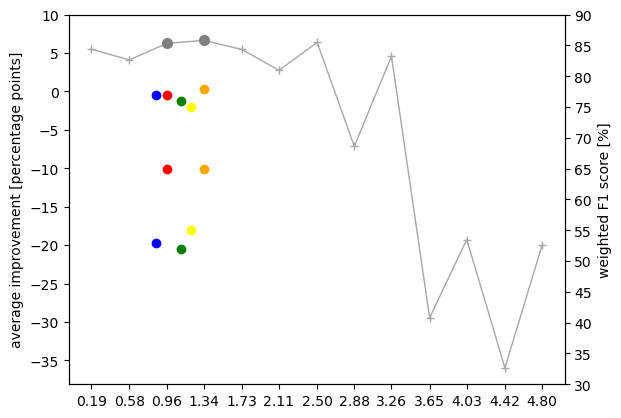

None

In [39]:
import pickle
def avg(lst):
    return sum(lst)/len(lst)
# We make a list of weighted f1_scores that we saved from different models while testing on different datasets
RU = pickle.load(open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysis/R->U/RU.pkl', 'rb'))
UR = pickle.load(open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysis/U->R/UR.pkl', 'rb')) 

res_tab = []

for j in range(len(RU)):
    data = [
        #pickle.load(open('./datasets/rawTS/| HolyDataset |/LOL3.pkl','rb')),
        RU[j],
        pickle.load(open('./datasets/rawTS/| HolyDataset |/LOL2.pkl','rb')),
        pickle.load(open('./datasets/rawTS/| HolyDataset |/Tanoni.pkl','rb')),
        pickle.load(open('./datasets/rawTS/| HolyDataset |/VGG11.pkl','rb')),

        #pickle.load(open('./datasets/rawTS/| HolyDataset |/LOL3_DALE.pkl','rb')),
        UR[j],
        pickle.load(open('./datasets/rawTS/| HolyDataset |/LOL2_DALE.pkl','rb')),
        pickle.load(open('./datasets/rawTS/| HolyDataset |/Tanoni_DALE.pkl','rb')),
        pickle.load(open('./datasets/rawTS/| HolyDataset |/VGG11_DALE.pkl','rb'))
    ]
    results = []
    for i in range(len(data)):
        # when i = 0 or i = 4 we are on the PirnatCross1 f1_score
        if i == 0 or i == 4:
            continue
        else: 
            # we calculate the difference between the scores from PirnatCross1 and other models and then append it to results tabel
            if i < 4:
                results.append(data[0]-data[i])
            else:
                results.append(data[4]-data[i])

    print(data)
    print(results)
    print(f"{round(avg(results)*100, 2)} %")
    res_tab.append(round(avg(results)*100, 2))
    
flops_tab = []
test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
for i in range(len(test_koef)):
    flops_tab.append(round(test_koef[i]*1.92, 2))
    

import matplotlib.pyplot as plt
"""
    WE MAKE A GRAPH THAT HAS THE BEST KOEF MARKED
"""
G1, G2, G3, G4, G5 = '#5c5c5c', '#757575', '#8f8f8f', '#a8a8a8', '#b5b5b5'
C1, C2, C3, C4 = '#2a3f78', '#7a72d2', '#96b5f6', '#3c2323'
color_list = [G4]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(flops_tab, res_tab, "+", linewidth = 2, label="trained: REFIT, tested: UK-DALE")
ax1.plot(flops_tab, res_tab, linewidth = 1)
ax1.scatter(1.34, 6.66, zorder = 5, linewidth = 2, color = "grey")
ax1.scatter(0.96, 6.25, zorder = 5, linewidth = 2, color = "grey")
ax2.scatter(0.85, 53, zorder = 5, linewidth = 1, color = "blue", label = "PirnatEco2")
ax2.scatter(0.85, 77, zorder = 5, linewidth = 1, color = "blue", label = "PirnatEco2")
ax2.scatter(1.11, 52, zorder = 5, linewidth = 1, color = "green", label = "Tanoni CRNN")
ax2.scatter(1.11, 76, zorder = 5, linewidth = 1, color = "green", label = "Tanoni CRNN")
ax2.scatter(1.21, 55, zorder = 5, linewidth = 1, color = "yellow", label = "VGG1")
ax2.scatter(1.21, 75, zorder = 5, linewidth = 1, color = "yellow", label = "VGG1")
ax2.scatter(1.34, 78, zorder = 5, linewidth = 1, color = "orange", label = "PirnatC")
ax2.scatter(1.34, 65, zorder = 5, linewidth = 1, color = "orange")
ax2.scatter(0.96, 77, zorder = 5, linewidth = 1, color = "red")
ax2.scatter(0.96, 65, zorder = 5, linewidth = 1, color = "red")

ax1.set_ylabel('average improvement [percentage points]')
ax2.set_ylabel('weighted F1 score [%]')
plt.xlabel('GFLOPs')
plt.xticks(flops_tab)  # set x-axis tick values
ax1.set_yticks([-35,-30,-25,-20,-15,-10,-5,0,5,10])  # set x-axis tick values
ax2.set_yticks([30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
plt.legend()
plt.savefig("FINAL_ANALYSIS4.pdf")
display(plt.show())

## Complexity analysis

In [ ]:
import tensorflow
from tensorflow.keras.callbacks import LearningRateScheduler

# define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

epochs = 20
window_size = 2550
batch_size = 128
NmDevices = 5
table_of_options = [1,2,3,4]
gru = True
gru_num = 64



HolyDataset = pickle.load(open('./datasets/rawTS/HolyDataset.pkl', 'rb'))

"""
# sanity checks
print(HolyDataset[0].shape, HolyDataset[1].shape, HolyDataset[2].shape, HolyDataset[3].shape, HolyDataset[4])
for i in range(10):
    print(HolyDataset[3][i])
"""
x_train = HolyDataset[0]
x_test = HolyDataset[1]
y_train = HolyDataset[2]
y_test = HolyDataset[3]
labels = HolyDataset[4]

HolyDataset_DALE = pickle.load(open('./datasets/rawTS/HolyDatasetDALE.pkl', 'rb'))
x_train_DALE = HolyDataset_DALE[0]
x_test_DALE = HolyDataset_DALE[1]
y_train_DALE = HolyDataset_DALE[2]
y_test_DALE = HolyDataset_DALE[3]
labels_DALE = HolyDataset_DALE[4]

class_weights = class_weights_tool(y_test)

test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]

RR, RU, UR, UU = [], [], [], []

for i in range(len(test_koef)):
    k = test_koef[i]
    print(k)
    # create a learning rate scheduler object
    lr_scheduler = LearningRateScheduler(scheduler)
    # |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
    model = TEST(k,NmDevices, window_size, 'gru', 64)
    model.build((len(y_train)+len(y_test),window_size,1))
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])
    #model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights, callbacks=[lr_scheduler])
    # |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
    model.save(f'./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*{k}/')
    
    
    # |||||||||||||||||||||||||||||||| prediction RR ||||||||||||||||||||||||||||||||
    y_pred = model.predict(x_test)
    y_pred_tf = (y_pred > 0.5)
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print(f"PC1*{k}")
    print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
    wf1 = metrics.f1_score(y_test, 
                           y_pred_tf, 
                           labels=None, 
                           pos_label=1, 
                           average='weighted', 
                           sample_weight=None, 
                           zero_division=0)
    RR.append(wf1)
    pickle.dump(wf1, open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysisAL/R->R/PC1*{k}.pkl', 'wb'))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    # |||||||||||||||||||||||||||||||| prediction RU ||||||||||||||||||||||||||||||||
    y_pred = model.predict(x_test_DALE)
    y_pred_tf = (y_pred > 0.5)
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print(f"PC1*{k}")
    print(metrics.classification_report(y_test_DALE, y_pred_tf, target_names=labels, zero_division=0))
    wf1 = metrics.f1_score(y_test_DALE, 
                           y_pred_tf, 
                           labels=None, 
                           pos_label=1, 
                           average='weighted', 
                           sample_weight=None, 
                           zero_division=0)
    RU.append(wf1)
    pickle.dump(wf1, open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysisAL/R->U/PC1*{k}.pkl', 'wb'))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    
for i in range(len(test_koef)):
    k = test_koef[i]
    print(k)
    # |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
    model = TEST(k,NmDevices, window_size, 'gru', 64)
    model.build((len(y_train)+len(y_test),window_size,1))
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])
    model.fit(x_train_DALE, y_train_DALE, batch_size=batch_size, epochs=epochs, class_weight=class_weights)
    # |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
    model.save(f'./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*{k}_DALE/')
    
    
    # |||||||||||||||||||||||||||||||| prediction UR ||||||||||||||||||||||||||||||||
    y_pred = model.predict(x_test)
    y_pred_tf = (y_pred > 0.5)
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print(f"PC1*{k}")
    print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
    wf1 = metrics.f1_score(y_test, 
                           y_pred_tf, 
                           labels=None, 
                           pos_label=1, 
                           average='weighted', 
                           sample_weight=None, 
                           zero_division=0)
    UR.append(wf1)
    pickle.dump(wf1, open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysisAL/U->R/PC1*{k}.pkl', 'wb'))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    # |||||||||||||||||||||||||||||||| prediction UU ||||||||||||||||||||||||||||||||
    y_pred = model.predict(x_test_DALE)
    y_pred_tf = (y_pred > 0.5)
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print(f"PC1*{k}")
    print(metrics.classification_report(y_test_DALE, y_pred_tf, target_names=labels, zero_division=0))
    wf1 = metrics.f1_score(y_test_DALE, 
                           y_pred_tf, 
                           labels=None, 
                           pos_label=1, 
                           average='weighted', 
                           sample_weight=None, 
                           zero_division=0)
    UU.append(wf1)
    pickle.dump(wf1, open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysisAL/U->U/PC1*{k}.pkl', 'wb'))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

pickle.dump(RR, open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysisAL/R->R/RR.pkl', 'wb'))    
pickle.dump(RU, open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysisAL/R->U/RU.pkl', 'wb'))
pickle.dump(UR, open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysisAL/U->R/UR.pkl', 'wb'))
pickle.dump(UU, open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysisAL/U->U/UU.pkl', 'wb'))
print(RR)
print(RU)
print(UR)
print(UU)



"""
    WE ANALYSE THE RELATION BETWEEN NM.FILTERS AND PERFORMANCE
"""


import matplotlib.pyplot as plt

x = test_koef

plt.plot(x, RR, "x", linewidth = 3, label="RR")
plt.plot(x, RU, "o", linewidth = 3, label="RU")
plt.plot(x, UR, "s", linewidth = 3, label="UR")
plt.plot(x, UU, "^", linewidth = 3, label="UU")

plt.plot(x, RR, linewidth = 1)
plt.plot(x, RU, linewidth = 1)
plt.plot(x, UR, linewidth = 1)
plt.plot(x, UU, linewidth = 1)

plt.ylabel('weighted F1 score')
plt.xlabel('koeficient of multiplication')
plt.legend()
plt.savefig("ANALYSIS2.pdf")
display(plt.show())

0.1
GRU enabled
Model: "TEST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2550, 1)]         0         
                                                                 
 block1_conv1 (Conv1D)       (None, 2550, 6)           24        
                                                                 
 block1_conv2 (Conv1D)       (None, 2550, 6)           114       
                                                                 
 block1_pool (MaxPooling1D)  (None, 1275, 6)           0         
                                                                 
 block2_conv1 (Conv1D)       (None, 1275, 12)          228       
                                                                 
 block2_conv2 (Conv1D)       (None, 1275, 12)          444       
                                                                 
 block2_pool (MaxPooling1D)  (None, 637, 12)  

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.1/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.1/assets


750/750 [==============================] - 3s 3ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.1
                 precision    recall  f1-score   support

         fridge       0.90      0.89      0.90     14772
washing machine       0.89      0.76      0.82     10509
    dish washer       0.86      0.70      0.77     10465
      microwave       0.86      0.82      0.84     11878
         kettle       0.95      0.91      0.93     12376

      micro avg       0.90      0.82      0.86     60000
      macro avg       0.89      0.82      0.85     60000
   weighted avg       0.89      0.82      0.86     60000
    samples avg       0.90      0.84      0.85     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 2s 3ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.1
                 precision    recall  f1-score   support

         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.3/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.3/assets


750/750 [==============================] - 3s 3ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.3
                 precision    recall  f1-score   support

         fridge       0.91      0.93      0.92     14772
washing machine       0.91      0.83      0.87     10509
    dish washer       0.89      0.81      0.85     10465
      microwave       0.92      0.86      0.88     11878
         kettle       0.97      0.93      0.95     12376

      micro avg       0.92      0.88      0.90     60000
      macro avg       0.92      0.87      0.89     60000
   weighted avg       0.92      0.88      0.90     60000
    samples avg       0.93      0.90      0.90     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 3s 3ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.3
                 precision    recall  f1-score   support

         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.5/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.5/assets


750/750 [==============================] - 3s 3ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.5
                 precision    recall  f1-score   support

         fridge       0.93      0.92      0.93     14772
washing machine       0.90      0.86      0.88     10509
    dish washer       0.89      0.83      0.86     10465
      microwave       0.92      0.86      0.89     11878
         kettle       0.95      0.95      0.95     12376

      micro avg       0.92      0.89      0.90     60000
      macro avg       0.92      0.88      0.90     60000
   weighted avg       0.92      0.89      0.90     60000
    samples avg       0.93      0.91      0.91     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 3s 3ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.5
                 precision    recall  f1-score   support

         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.9/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.9/assets


750/750 [==============================] - 5s 6ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.9
                 precision    recall  f1-score   support

         fridge       0.92      0.93      0.93     14772
washing machine       0.89      0.88      0.89     10509
    dish washer       0.88      0.85      0.86     10465
      microwave       0.91      0.87      0.89     11878
         kettle       0.96      0.94      0.95     12376

      micro avg       0.92      0.90      0.91     60000
      macro avg       0.91      0.90      0.90     60000
   weighted avg       0.92      0.90      0.91     60000
    samples avg       0.93      0.91      0.91     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 5s 7ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.9
                 precision    recall  f1-score   support

         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.1/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.1/assets


750/750 [==============================] - 7s 8ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.1
                 precision    recall  f1-score   support

         fridge       0.93      0.92      0.93     14772
washing machine       0.92      0.86      0.89     10509
    dish washer       0.86      0.86      0.86     10465
      microwave       0.90      0.88      0.89     11878
         kettle       0.98      0.93      0.95     12376

      micro avg       0.92      0.89      0.91     60000
      macro avg       0.92      0.89      0.90     60000
   weighted avg       0.92      0.89      0.91     60000
    samples avg       0.93      0.91      0.91     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 6s 8ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.1
                 precision    recall  f1-score   support

         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.3/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.3/assets


750/750 [==============================] - 8s 9ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.3
                 precision    recall  f1-score   support

         fridge       0.95      0.91      0.93     14772
washing machine       0.93      0.85      0.89     10509
    dish washer       0.89      0.85      0.87     10465
      microwave       0.91      0.87      0.89     11878
         kettle       0.95      0.95      0.95     12376

      micro avg       0.93      0.89      0.91     60000
      macro avg       0.93      0.89      0.91     60000
   weighted avg       0.93      0.89      0.91     60000
    samples avg       0.94      0.91      0.91     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 8s 10ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.3
                 precision    recall  f1-score   support

        

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.5/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.5/assets


750/750 [==============================] - 7s 7ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.5
                 precision    recall  f1-score   support

         fridge       0.93      0.92      0.93     14772
washing machine       0.91      0.88      0.89     10509
    dish washer       0.90      0.86      0.88     10465
      microwave       0.92      0.87      0.89     11878
         kettle       0.97      0.94      0.95     12376

      micro avg       0.93      0.89      0.91     60000
      macro avg       0.93      0.89      0.91     60000
   weighted avg       0.93      0.89      0.91     60000
    samples avg       0.94      0.91      0.92     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 7s 9ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.5
                 precision    recall  f1-score   support

         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.7/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.7/assets


750/750 [==============================] - 11s 12ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.7
                 precision    recall  f1-score   support

         fridge       0.63      1.00      0.77     14772
washing machine       0.89      0.37      0.52     10509
    dish washer       0.93      0.38      0.54     10465
      microwave       0.78      0.44      0.56     11878
         kettle       0.98      0.64      0.77     12376

      micro avg       0.76      0.59      0.67     60000
      macro avg       0.84      0.56      0.63     60000
   weighted avg       0.83      0.59      0.65     60000
    samples avg       0.72      0.59      0.62     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 11s 14ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.7
                 precision    recall  f1-score   support

     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.9/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*1.9/assets


750/750 [==============================] - 12s 14ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.9
                 precision    recall  f1-score   support

         fridge       0.63      0.90      0.74     14772
washing machine       0.62      0.00      0.00     10509
    dish washer       0.53      0.26      0.35     10465
      microwave       0.77      0.35      0.48     11878
         kettle       0.53      0.52      0.53     12376

      micro avg       0.61      0.44      0.51     60000
      macro avg       0.62      0.41      0.42     60000
   weighted avg       0.62      0.44      0.45     60000
    samples avg       0.54      0.44      0.45     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 12s 16ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*1.9
                 precision    recall  f1-score   support

     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*2.1/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*2.1/assets


750/750 [==============================] - 15s 17ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*2.1
                 precision    recall  f1-score   support

         fridge       0.94      0.92      0.93     14772
washing machine       0.88      0.86      0.87     10509
    dish washer       0.86      0.83      0.85     10465
      microwave       0.90      0.87      0.88     11878
         kettle       0.96      0.94      0.95     12376

      micro avg       0.91      0.89      0.90     60000
      macro avg       0.91      0.88      0.90     60000
   weighted avg       0.91      0.89      0.90     60000
    samples avg       0.93      0.90      0.91     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 15s 19ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*2.1
                 precision    recall  f1-score   support

     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*2.3/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*2.3/assets


750/750 [==============================] - 16s 19ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*2.3
                 precision    recall  f1-score   support

         fridge       0.61      0.66      0.64     14772
washing machine       0.43      0.24      0.31     10509
    dish washer       0.00      0.00      0.00     10465
      microwave       0.62      0.36      0.45     11878
         kettle       0.53      0.37      0.44     12376

      micro avg       0.57      0.35      0.43     60000
      macro avg       0.44      0.33      0.37     60000
   weighted avg       0.46      0.35      0.39     60000
    samples avg       0.36      0.38      0.33     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 16s 21ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*2.3
                 precision    recall  f1-score   support

     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*2.5/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*2.5/assets


750/750 [==============================] - 16s 15ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*2.5
                 precision    recall  f1-score   support

         fridge       0.61      0.84      0.71     14772
washing machine       0.00      0.00      0.00     10509
    dish washer       0.40      0.33      0.36     10465
      microwave       0.49      0.83      0.62     11878
         kettle       0.54      0.42      0.48     12376

      micro avg       0.53      0.52      0.52     60000
      macro avg       0.41      0.48      0.43     60000
   weighted avg       0.43      0.52      0.46     60000
    samples avg       0.43      0.53      0.44     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 16s 20ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*2.5
                 precision    recall  f1-score   support

     

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.1_DALE/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.1_DALE/assets


750/750 [==============================] - 3s 4ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.1
                 precision    recall  f1-score   support

         fridge       0.77      0.33      0.46     14772
washing machine       0.53      0.88      0.66     10509
    dish washer       0.50      0.62      0.56     10465
      microwave       0.78      0.38      0.51     11878
         kettle       0.67      0.95      0.78     12376

      micro avg       0.61      0.62      0.61     60000
      macro avg       0.65      0.63      0.60     60000
   weighted avg       0.66      0.62      0.59     60000
    samples avg       0.60      0.59      0.57     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 3s 4ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.1
                 precision    recall  f1-score   support

         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.3_DALE/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.3_DALE/assets


750/750 [==============================] - 3s 4ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.3
                 precision    recall  f1-score   support

         fridge       0.76      0.43      0.55     14772
washing machine       0.54      0.90      0.67     10509
    dish washer       0.61      0.53      0.57     10465
      microwave       0.76      0.47      0.58     11878
         kettle       0.67      0.94      0.79     12376

      micro avg       0.65      0.64      0.65     60000
      macro avg       0.67      0.65      0.63     60000
   weighted avg       0.68      0.64      0.63     60000
    samples avg       0.63      0.62      0.60     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 3s 4ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.3
                 precision    recall  f1-score   support

         

INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.5_DALE/assets


INFO:tensorflow:Assets written to: ./models/rawTS/HolyDataset/ComplexityAnalysisAL/PC1*0.5_DALE/assets


750/750 [==============================] - 3s 4ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.5
                 precision    recall  f1-score   support

         fridge       0.73      0.36      0.48     14772
washing machine       0.51      0.92      0.66     10509
    dish washer       0.63      0.50      0.56     10465
      microwave       0.71      0.49      0.58     11878
         kettle       0.66      0.95      0.78     12376

      micro avg       0.63      0.63      0.63     60000
      macro avg       0.65      0.64      0.61     60000
   weighted avg       0.66      0.63      0.61     60000
    samples avg       0.60      0.61      0.58     60000

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
750/750 [==============================] - 3s 4ms/step
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
PC1*0.5
                 precision    recall  f1-score   support

         

[85.68309310126354, 90.02695933288686, 90.48852308493292, 90.38654799249926, 90.75418503763666, 90.92969916281423, 90.62071640864836, 53.54437769927214, 83.9145868165733, 31.34144615286698, 39.89701952017457, 24.720104334020057, 34.91648820074532]
[76.79269918128679, 77.04236685467205, 77.38570352768156, 78.06925971793662, 77.04840704683498, 77.60211595398606, 77.2163894623964, 66.18498806246019, 78.4868919011588, 43.495783859106005, 47.26756976341457, 31.500359994918785, 33.629369324221244]
[63.637795899371085, 60.58517124537073, 64.53254201120794, 64.65227528300028, 63.30287467674053, 57.33920494143418, 64.96605686214515, 48.95533912559791, 60.09290381644974, 27.02555138805472, 43.60569124207168, 25.95595394230016, 55.78784143096115]
[92.04767318301357, 93.12388600453822, 93.96048262955301, 93.81276448166179, 94.65140121535913, 70.11871519378022, 93.88475581691279, 56.22886225173659, 94.57557859210148, 48.96320970817942, 63.56935728908096, 31.164974632261387, 95.21942955546557]


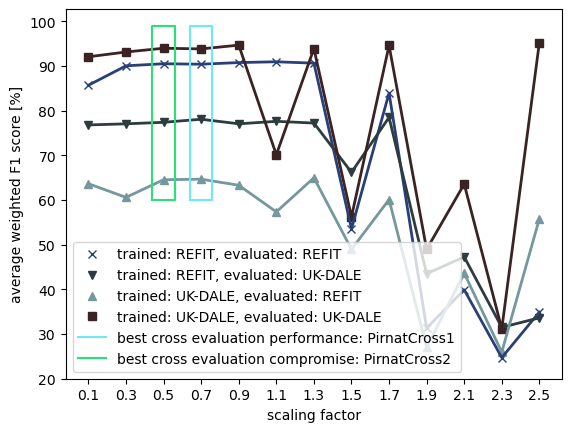

None

0.7 0.9


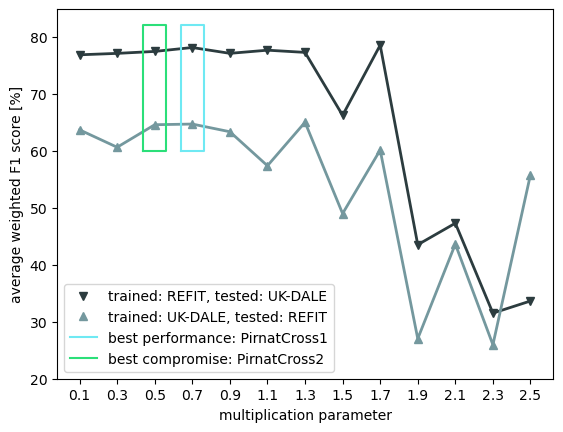

None

In [53]:
def BestKoef(lst1, lst2):
    # We find the test that had the highest number in sum of 2 lists
    sum_list = []
    M, bestKoef = 0, 0
    for i in range(len(lst1)):
        sum_list.append(lst1[i]+lst2[i])
    for j in range(len(sum_list)):
        if sum_list[j] == max(sum_list): M = j 
    test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
    bestKoef = test_koef[M]
    return bestKoef

def BestElement(lst1, lst2):
    # We find the test that had the highest number in sum of 2 lists
    sum_list = []
    M, bestKoef = 0, 0
    for i in range(len(lst1)):
        sum_list.append(lst1[i]+lst2[i])
    for j in range(len(sum_list)):
        if sum_list[j] == max(sum_list): M = j 
    test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
    bestKoef = test_koef[M]
    return M

def MultiplyElements(lst, multiplier):
    result = []
    for num in lst:
        result.append(num * multiplier)
    return result


import pickle

test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]

RR = pickle.load(open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysis/R->R/RR.pkl', 'rb'))    
RU = pickle.load(open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysis/R->U/RU.pkl', 'rb'))
UR = pickle.load(open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysis/U->R/UR.pkl', 'rb'))
UU = pickle.load(open(f'./datasets/rawTS/| HolyDataset |/ComplexityAnalysis/U->U/UU.pkl', 'rb'))
RR = MultiplyElements(RR, 100)
RU = MultiplyElements(RU, 100)
UR = MultiplyElements(UR, 100)
UU = MultiplyElements(UU, 100)
print(RR)
print(RU)
print(UR)
print(UU)



"""
    WE ANALYSE THE RELATION BETWEEN NM.FILTERS AND PERFORMANCE
"""


import matplotlib.pyplot as plt

x = test_koef

C1, C4 = '#2a3f78', '#3c2323'
C2, C3 = '#2c3c3f', '#74989e'
#C5, C6 = '#6fe9f3', '#2bdf79'
color_list = [C1, C2, C3, C4]#, C5, C6]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

# Lines
plt.plot(x, RR, "x", linewidth = 3, label="trained: REFIT, evaluated: REFIT")
plt.plot(x, RU, "v", linewidth = 3, label="trained: REFIT, evaluated: UK-DALE")
plt.plot(x, UR, "^", linewidth = 3, label="trained: UK-DALE, evaluated: REFIT")
plt.plot(x, UU, "s", linewidth = 3, label="trained: UK-DALE, evaluated: UK-DALE")

# Marks
plt.plot(x, RR, linewidth = 2)
plt.plot(x, RU, linewidth = 2)
plt.plot(x, UR, linewidth = 2)
plt.plot(x, UU, linewidth = 2)

# Squares around PC1 and PC2
# PC1
xs1 = [0.64, 0.64, 0.76, 0.76, 0.64]
ys1 = [60, 99, 99, 60, 60]
plt.plot(xs1, ys1, color = C5, label = 'best cross evaluation performance: PirnatCross1')
# PC2
xs2 = [0.44, 0.44, 0.56, 0.56, 0.44]
ys2 = [60, 99, 99, 60, 60]
plt.plot(xs2, ys2, color = C6, label = 'best cross evaluation compromise: PirnatCross2')

plt.ylabel('average weighted F1 score [%]')
plt.yticks([20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('scaling factor')
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5])  # set x-axis tick values
plt.legend()
#plt.savefig("ANALYSIS.pdf")
plt.savefig("ANALYSIS_colored_WPC1PC2.pdf")
display(plt.show())


"""
    WE DECIDE ON THE BEST NM.FILTERS PURELY ON PERFORMANCE
"""

print(BestKoef(UR, RU), BestKoef(UU, RR))

"""
    WE MAKE A GRAPH THAT HAS THE BEST KOEF MARKED
"""
G1, G2, G3, G4, G5 = '#5c5c5c', '#757575', '#8f8f8f', '#a8a8a8', '#b5b5b5'
#C1, C2, C3, C4 = '#2a3f78', '#7a72d2', '#96b5f6', '#3c2323'
C1, C2 = '#2a3f78', '#3c2323'
C2, C3 = '#2c3c3f', '#74989e'
C5, C6 = '#6fe9f3', '#2bdf79'


#color_list = [G1,G2,G3,G4,G5]
#color_list = [G1,G4]
#color_list = [C1,C2,C3,C4]
color_list = [C2, C3]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

# Lines
plt.plot(x, RU, "v", linewidth = 3, label="trained: REFIT, tested: UK-DALE")#, label="trained: REFIT, tested: UK-DALE")
plt.plot(x, UR, "^", linewidth = 3, label="trained: UK-DALE, tested: REFIT")#, label="trained: UK-DALE, tested: REFIT")

# Marks
plt.plot(x, RU, linewidth = 2)
plt.plot(x, UR, linewidth = 2)

# Marks for PC1 and PC2
#plt.scatter([BestKoef(UR, RU)], UR[BestElement(UR, RU)], zorder = 5, linewidth = 2, marker = '^', color = C5)#, label='best performance: PirnatCross1')
#plt.scatter([BestKoef(UR, RU)], RU[BestElement(UR, RU)], zorder = 5, linewidth = 2, marker = 'v', color = C5)
#plt.scatter(0.5, 0.6453254201120794*100, zorder = 5,  linewidth = 2, marker = '^', color = C6)#, label='best compromise: PirnatCross2')
#plt.scatter(0.5, 0.7738570352768156*100, zorder = 5,  linewidth = 2, marker = 'v', color = C6)


# Squares around PC1 and PC2
# PC1
xs1 = [0.64, 0.64, 0.76, 0.76, 0.64]
ys1 = [60, 82, 82, 60, 60]
plt.plot(xs1, ys1, color = C5, label = 'best performance: PirnatCross1')
# PC2
xs2 = [0.44, 0.44, 0.56, 0.56, 0.44]
ys2 = [60, 82, 82, 60, 60]
plt.plot(xs2, ys2, color = C6, label = 'best compromise: PirnatCross2')

# Plt parameters
plt.ylabel('average weighted F1 score [%]')
plt.yticks([20, 30, 40, 50, 60, 70, 80])
plt.xlabel('multiplication parameter')
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5])  # set x-axis tick values
plt.legend()





plt.savefig("FINAL_ANALYSIS_PC1&PC2_colored.pdf")
display(plt.show())

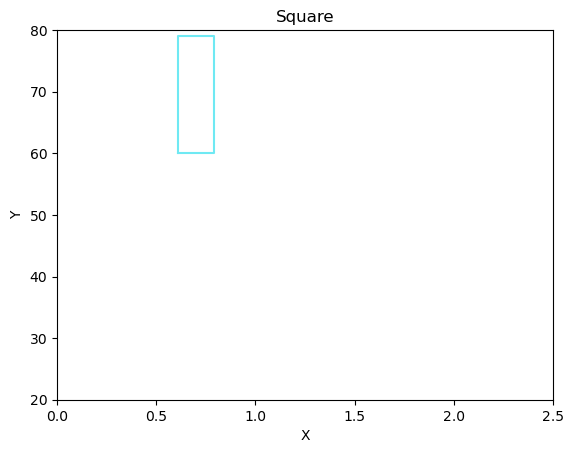

In [37]:
import matplotlib.pyplot as plt

x = [0.61, 0.61, 0.79, 0.79, 0.61]
y = [60, 79, 79, 60, 60]

fig, ax = plt.subplots()
ax.plot(x, y, color = C5)

ax.set_xlim([0, 2.5])
ax.set_ylim([20, 80])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Square')
#ax.grid(True)

plt.show()


In [12]:
def BestKoef(lst1, lst2):
    # We find the test that had the highest number in sum of 2 lists
    sum_list = []
    M, bestKoef = 0, 0
    for i in range(len(lst1)):
        sum_list.append(lst1[i]+lst2[i])
    for j in range(len(sum_list)):
        if sum_list[j] == max(sum_list): M = j 
    test_koef = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
    bestKoef = test_koef[M]
    return bestKoef
print(RU)
print(UR)
BestOf2Lists(RU, UR)

[0.7679269918128679, 0.7704236685467205, 0.7738570352768156, 0.7806925971793661, 0.7704840704683499, 0.7760211595398606, 0.7721638946239641, 0.6618498806246019, 0.7848689190115881, 0.43495783859106, 0.4726756976341457, 0.31500359994918786, 0.3362936932422124]
[0.6363779589937109, 0.6058517124537073, 0.6453254201120794, 0.6465227528300028, 0.6330287467674053, 0.5733920494143419, 0.6496605686214515, 0.4895533912559791, 0.6009290381644974, 0.2702555138805472, 0.43605691242071676, 0.2595595394230016, 0.5578784143096115]


([1.4043049508065788,
  1.3762753810004278,
  1.419182455388895,
  1.427215350009369,
  1.4035128172357552,
  1.3494132089542026,
  1.4218244632454156,
  1.151403271880581,
  1.3857979571760854,
  0.7052133524716072,
  0.9087326100548625,
  0.5745631393721895,
  0.8941721075518239],
 1.427215350009369,
 0.7)

# USE THIS

In [18]:
"""
               USES THE HOLY DATASET, OUR, EXPERIMENT WITH KFOLD!!!!!
               
            
"""


epochs = 20
window_size = 2550
batch_size = 128
NmDevices = 5
# table_of_options = [1,2,3,4]
k = 1


import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import pickle

# Define a learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Load the datasets
HolyDataset_UKD = pickle.load(open('./datasets/HolyDatasetDALE.pkl', 'rb'))
HolyDataset_REF = pickle.load(open('./datasets/HolyDataset.pkl', 'rb'))

x_UKD, y_UKD, labels_UKD = HolyDataset_UKD[0], HolyDataset_UKD[2], HolyDataset_UKD[4]
class_weights_UKD = class_weights_tool(y_UKD)

x_REF, y_REF, labels_REF = HolyDataset_REF[0], HolyDataset_REF[2], HolyDataset_REF[4]
class_weights_REF = class_weights_tool(y_REF)


# Lists to store the evaluation results for each fold
evaluation_results_UKD_UKD, evaluation_results_UKD_REF, evaluation_results_REF_UKD, evaluation_results_REF_REF = [], [], [], []

# x_train_UKD, x_val_UKD = x_UKD[train_idx], x_UKD[val_idx]
# y_train_UKD, y_val_UKD = y_UKD[train_idx], y_UKD[val_idx]





"""
Train on UKD, evaluate on REF
"""


model = NUK.PC0(NmDevices, window_size, 'gru', 128, k)
model.build((len(y_train_UKD) + len(y_test_UKD), window_size, 1))
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=[NUK.F1Score, NUK.WeightedF1Score(NUK.class_weights_tool(y_test_UKD))])
lr_scheduler = LearningRateScheduler(scheduler)
model.fit(x_train_UKD, y_train_UKD, batch_size=batch_size, epochs=epochs, class_weight=class_weights_UKD, callbacks=[lr_scheduler])

# Evaluate the model on the UKD dataset
y_pred_UKD = model.predict(x_val_UKD)
y_pred_tf_UKD = (y_pred_UKD > 0.5)
report_UKD = metrics.classification_report(y_val_UKD, y_pred_tf_UKD, target_names=labels_UKD, zero_division=0)
# I prefer to save class. reports in pandas dataframes so i use this function
report_UKD_DF = NUK.ClassificationReportToDF(report_UKD, labels_UKD)
report_UKD_DF.rename(columns={report_UKD_DF.columns[0]: "device"}, inplace=True)
evaluation_results_UKD_UKD.append(report_UKD_DF)

# Evaluate the model on the REF dataset
y_pred_REF = model.predict(x_REF)
y_pred_tf_REF = (y_pred_REF > 0.5)
report_REF = metrics.classification_report(y_REF, y_pred_tf_REF, target_names=labels_REF, zero_division=0)
# I prefer to save class. reports in pandas dataframes so i use this function
report_REF_DF = NUK.ClassificationReportToDF(report_REF, labels_REF)
report_REF_DF.rename(columns={report_REF_DF.columns[0]: "device"}, inplace = True)
evaluation_results_UKD_REF.append(report_REF_DF)



"""
Train on REF, evaluate on UKD
"""

# x_train_REF, x_val_REF = x_REF[train_idx], x_REF[val_idx]  # Swap 'x_train_UKD' with 'x_train_REF' and 'x_val_UKD' with 'x_val_REF'
# y_train_REF, y_val_REF = y_REF[train_idx], y_REF[val_idx]  # Swap 'y_train_UKD' with 'y_train_REF' and 'y_val_UKD' with 'y_val_REF'


model = NUK.PC0(NmDevices, window_size, 'gru', 128, k)
model.build((len(y_train_REF) + len(y_test_REF), window_size, 1))  # Swap 'y_train_UKD' with 'y_train_REF'
#model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=[NUK.F1Score, NUK.WeightedF1Score(NUK.class_weights_tool(y_test_REF))])  # Swap 'y_test_UKD' with 'y_test_REF'
lr_scheduler = LearningRateScheduler(scheduler)
model.fit(x_train_REF, y_train_REF, batch_size=batch_size, epochs=epochs, class_weight=class_weights_REF, callbacks=[lr_scheduler])  # Swap 'x_train_UKD' with 'x_train_REF' and 'y_train_UKD' with 'y_train_REF'

# Evaluate the model on the REF dataset  # Swap 'UKD' with 'REF'
y_pred_REF = model.predict(x_val_REF)  # Swap 'x_val_UKD' with 'x_val_REF'
y_pred_tf_REF = (y_pred_REF > 0.5)
report_REF = metrics.classification_report(y_val_REF, y_pred_tf_REF, target_names=labels_REF, zero_division=0)  # Swap 'y_val_UKD' with 'y_val_REF'
# I prefer to save class. reports in pandas dataframes so i use this function
report_REF_DF = NUK.ClassificationReportToDF(report_REF, labels_REF)
report_REF_DF.rename(columns={report_REF_DF.columns[0]: "device"}, inplace=True)
evaluation_results_REF_REF.append(report_REF_DF)  # Swap 'evaluation_results_UKD_REF' with 'evaluation_results_REF_REF'

# Evaluate the model on the UKD dataset  # Swap 'REF' with 'UKD'
y_pred_UKD = model.predict(x_UKD)  # Swap 'x_REF' with 'x_UKD'
y_pred_tf_UKD = (y_pred_UKD > 0.5)
report_UKD = metrics.classification_report(y_UKD, y_pred_tf_UKD, target_names=labels_UKD, zero_division=0)  # Swap 'y_REF' with 'y_UKD'
# I prefer to save class. reports in pandas dataframes so i use this function
report_UKD_DF = NUK.ClassificationReportToDF(report_UKD, labels_UKD)
report_UKD_DF.rename(columns={report_UKD_DF.columns[0]: "device"}, inplace=True)
evaluation_results_REF_UKD.append(report_UKD_DF)  # Swap 'evaluation_results_UKD_UKD' with 'evaluation_results_REF_UKD'




print(evaluation_results_UKD_UKD, evaluation_results_UKD_REF, evaluation_results_REF_UKD, evaluation_results_REF_REF)

GRU enabled


NameError: name 'y_train_UKD' is not defined